In [27]:
! pip install geopandas
! pip install pandas
! pip install pygeos
! pip install boto
! pip install s3fs
! pip install shapely
! pip install gcsfs
!pip install contextily
!pip install matplotlib-scalebar
!pip install sklearn
!pip install zipfile
!pip install random
import random
import numpy as np
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import time
from itertools import groupby
import geopandas as gpd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from matplotlib.ticker import FuncFormatter



  Using cached sklearn-0.0.post11.tar.gz (3.6 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post11-py3-none-any.whl size=2959 sha256=d4c8b0e2e2bdf981ca945bd1048258bc3a54c04ece88de96ad6f0ebdfdb96b3f
  Stored in directory: /home/jovyan/.cache/pip/wheels/84/1f/d1/dfa81208b4c94d2d378aecbb603d1659779c456441a67b3db7
Successfully built sklearn
ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile
ERROR: Could not find a version that satisfies the requirement random (from versions: none)
ERROR: No matching distribution found for random


In [5]:
person_table_path = 'outputs/person_databaseTR.csv'
Scale = 0.3

In [6]:
df = pd.read_csv(person_table_path)



/tmp/ipykernel_495493/2442904009.py:1: DtypeWarning: Columns (3,4,5,6,17,18,19,20,21,22,23,24,25,26,27,29,31,53,54,88,89,90,91,92,93,94,95,96,97,101,102,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(person_table_path)


In [7]:


nan_count = df['Person'].isna().sum()
df = df[df['Person'].notna()]
print("NaN:", len(df))
df = df[((df['Distance Walking INEXUS Baseline'] < 6000))]
print("Walk:", len(df))
df = df[((df['Distance Walking INEXUS TR'] < 6000))]
print("Walk TR:", len(df))

df = df[((df['Mode Choice Actual 5 INEXUS TR'] == 'transit'))]
print("Transit TR:", len(df))

df = df[((df['Distance Travelling INEXUS Baseline'] < 100000)&(df['Distance Travelling INEXUS Baseline'] >200))]
print("Distance:", len(df))
df = df[((df['Distance Travelling INEXUS TR'] < 100000)&(df['Distance Travelling INEXUS TR'] >200))]
print("Distance TR:", len(df))
df = df[((df['Distance Travelling INEXUS Diff'] < 50000)&(df['Distance Travelling INEXUS Diff'] >-50000))]
print("Distance Diff:", len(df))

df = df[((df['Duration Travelling INEXUS Baseline'] < 10000)&(df['Duration Travelling INEXUS Baseline'] >60))]
print("Duration:", len(df))
df = df[((df['Duration Travelling INEXUS TR'] < 10000)&(df['Duration Travelling INEXUS TR'] >60))]
print("Duration TR:", len(df))
df = df[((df['Duration Travelling INEXUS Diff'] < 5000)&(df['Duration Travelling INEXUS Diff'] >-5000))]
print("Duration Diff:", len(df))

df = df[((df['Potenzial Inexus INEXUS Baseline'] < 5)&(df['Potenzial Inexus INEXUS Baseline'] >-10))]
print("INEXUS:", len(df))
df = df[((df['Potenzial Inexus INEXUS TR'] < 5)&(df['Potenzial Inexus INEXUS TR'] >-10))]
print("INEXUS TR:", len(df))
df = df[((df['Potenzial Inexus INEXUS Diff'] < 1))]
print("INEXUS Diff:", len(df))


#'Mode Choice Actual 5 INEXUS TR'
#Distance Travelling INEXUS TR
#'Duration Travelling INEXUS TR'
#Potenzial Inexus INEXUS TR


NaN: 573902
Walk: 547090
Walk TR: 544027
Transit TR: 522267
Distance: 521423
Distance TR: 521104
Distance Diff: 521039
Duration: 520279
Duration TR: 520229
Duration Diff: 519748
INEXUS: 518750
INEXUS TR: 518701
INEXUS Diff: 511820


-9.990369025297356
2.8294248425997743


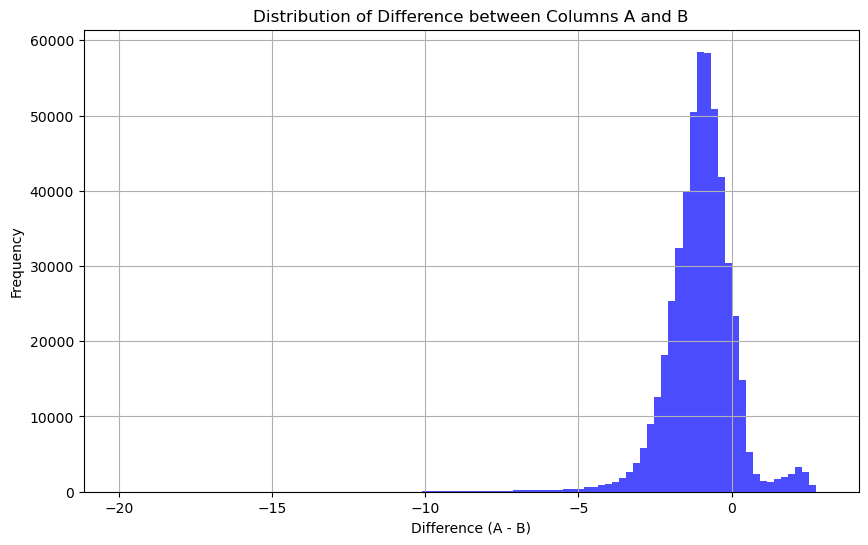

In [8]:
# PLOT TO CHECK DISTRIBUTION
print(df['Potenzial Inexus INEXUS Baseline'].min())
print(df['Potenzial Inexus INEXUS Baseline'].max())
plt.figure(figsize=(10,6))
plt.hist(df['Potenzial Inexus INEXUS Baseline'], bins=100, alpha=0.7, color='blue', range=(-20, 3))
plt.title('Distribution of Difference between Columns A and B')
plt.xlabel('Difference (A - B)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# ***PERSON TABLE ANALYSIS***

In [80]:
#Add Switch From Column SF - Van Ness
df['Project Tried'] = df['Project Tried'].replace({'BA:3 - BSVI': 'BART - BSVI', 'BA:5 - BSVI': 'BART - BSVI',
                                                   'BA:3 - BSVII': 'BART - BSVII', 'BA:5 - BSVII': 'BART - BSVII',})

switch_type = []
for agencies_baseline, project, mode_base in zip(df['Bus agencies Used Baseline'],df['Project Tried'], df['Mode Choice Actual 5 INEXUS Baseline']):
    if agencies_baseline == '[]' and mode_base != 'transit':
        switch_type.append('Switch from another mode')
    elif project in ['SF:T - TR', 'SF:49 - TR', 'SF:T - CS', 'SF:49 - VN'] and 'SF:' in agencies_baseline:
        switch_type.append('Switch from same transit agency')
    elif project in ['1TEMPO - 1T', '1TEMPO - TR'] and 'AC:' in agencies_baseline:
        switch_type.append('Switch from same transit agency')
    elif project in ['CALTRAIN - CA', 'CA - TR'] and 'cal' in agencies_baseline:
        switch_type.append('Switch from same transit agency')
    elif project in ['BART - TR','BART - BSV CORE','BART - BSVI','BART - BSVII','BART - CORE'] and 'BA:' in agencies_baseline:
        switch_type.append('Switch from same transit agency')
    else:
        switch_type.append('Switch from another transit agency')

df['Switch From'] = switch_type
print(len(df))



# df[:100].to_csv('outputs/person_databaseTR-upgraded.csv', index = False)


510816


In [10]:
df[['Switch From', 'Project Tried']].value_counts()

Switch From                         Project Tried  
Switch from same transit agency     BART - TR          99350
                                    BART - BSV CORE    99121
                                    BART - CORE        99094
                                    BART - BSVI        25489
                                    BART - BSVII       25265
Switch from another transit agency  BART - TR          24640
                                    BART - BSV CORE    24476
                                    BART - CORE        18759
Switch from another mode            BART - TR          11613
                                    BART - BSV CORE    11528
                                    BART - CORE        10895
Switch from another transit agency  BART - BSVII       10425
                                    BART - BSVI         5908
Switch from same transit agency     SF:49 - VN          4812
                                    SF:49 - TR          4586
                                 

In [11]:
import ast

df['Vehicles Used TR String'] = df['Vehicles Used TR'].apply(lambda x: x.replace("' '", "', '"))
df['Vehicles Used Baseline String'] = df['Vehicles Used Baseline'].apply(lambda x: x.replace("' '", "', '"))

# Load CSV files into DataFrames'outputs/routetovehicledictBaseline.csv',
dict0 = pd.read_csv('outputs/routetovehicledictBaseline.csv').set_index('0').to_dict()['1']
dict1 = pd.read_csv('outputs/routetovehicledictTR.csv').set_index('0').to_dict()['1']
dict2 = pd.read_csv('outputs/routetovehicledictTR-BA.csv').set_index('0').to_dict()['1']
dict3 = pd.read_csv('outputs/routetovehicledictTR-BSVI.csv').set_index('0').to_dict()['1']
dict4 = pd.read_csv('outputs/routetovehicledictTR-BSVII.csv').set_index('0').to_dict()['1']
dict5 = pd.read_csv('outputs/routetovehicledictTR-CORE.csv').set_index('0').to_dict()['1']
dict6 = pd.read_csv('outputs/routetovehicledictTR-1T.csv').set_index('0').to_dict()['1']
dict7 = pd.read_csv('outputs/routetovehicledictTR-CA.csv').set_index('0').to_dict()['1']
dict8 = pd.read_csv('outputs/routetovehicledictTR-CS.csv').set_index('0').to_dict()['1']
dict9 = pd.read_csv('outputs/routetovehicledictTR-VN.csv').set_index('0').to_dict()['1']

# Selector to dictionary mapping
selector_to_dict = {
    'BART - TR': dict1,
    '1TEMPO - TR': dict1,
    'CA - TR': dict1,
    'SF:T - TR': dict1,
    'SF:49 - TR': dict1,
    'BART - BSV CORE': dict2,
    'BART - BSVI': dict3,
    'BART - BSVII': dict4,
    'BART - CORE': dict5,
    '1TEMPO - 1T': dict6,
    'CALTRAIN - CA': dict7,
    'SF:T - CS': dict8,
    'SF:49 - VN': dict9,
}

def vehicle_to_route(vehicle_ids, route_dict):
    
    vehicle_ids = ast.literal_eval(vehicle_ids)
    return [route_dict[vehicle_id] for vehicle_id in vehicle_ids if vehicle_id in route_dict]


df['Routes Used Baseline'] = df.apply(
    lambda row: vehicle_to_route(row['Vehicles Used Baseline String'], dict0),
    axis=1
)
df['Routes Used TR'] = df.apply(
    lambda row: vehicle_to_route(row['Vehicles Used TR String'], selector_to_dict.get(row['Project Tried'])),
    axis=1
)



In [22]:
persons = pd.read_csv('gs://beam-core-outputs/sfbay-baseline2018-30pct-20230825/activitysim/final_persons.csv')
households = pd.read_csv('gs://beam-core-outputs/sfbay-baseline2018-30pct-20230825/activitysim/final_households.csv')

person_to_pincome = dict(zip(persons.person_id, persons.earning))
person_to_race = dict(zip(persons.person_id, persons.race_id))

person_to_hs = dict(zip(persons.person_id, persons.household_id))
hs_to_income = dict(zip(households.household_id, households.income_in_thousands*1000))
person_to_income = {key: hs_to_income[person_to_hs[key]] for key in person_to_hs}


df['HS Income'] = df['Person'].map(person_to_income) 
df['Person Income'] = df['Person'].map(person_to_pincome) 
df['Person Race ID'] = df['Person'].map(person_to_race) 

# df.to_csv('outputs/person_databaseTR-upgraded.csv', index = False)

NameError: name 'race_dict' is not defined

In [24]:
race_dict = {
    1: "White alone",
    2: "Black or African American alone",
    3: "American Indian alone",
    4: "Alaska Native alone",
    5: "American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other races",
    6: "Asian alone",
    7: "Native Hawaiian and Other Pacific Islander alone",
    8: "Some Other Race alone",
    9: "Two or More Races"
}
df['Person Race'] = df['Person Race ID'].map(race_dict) 


In [12]:
df['Project Tried'].value_counts()

BART - TR          135603
BART - BSV CORE    135125
BART - CORE        128748
BART - BSVII        39136
BART - BSVI         34210
SF:49 - VN           6640
SF:49 - TR           6369
CALTRAIN - CA        5028
CA - TR              4925
1TEMPO - 1T          4573
1TEMPO - TR          4529
SF:T - CS            3481
SF:T - TR            3453
Name: Project Tried, dtype: int64

In [33]:
df[:1000].to_csv('test.csv')

# **Ridership**value_counts

In [39]:
import ast


from_indexes = [

                '1', '49', 'K/T', 'J', 'L', 'M', 'N', 
                'BA - Blue', 'BA - Green', 'BA - Orange', 'BA - Red', 
                'BA - Yellow', 'Car', 'CarPool','TNC', 'TNC-Pool','Walk', 'Bike', 
    'CA', 'AC - others', 'SF - others','AM','AY','CC','CE','CM',
    'DE','EM','FF','GG','HF','MA','PE','RV', 'SB',
    'SC','SL','SM','SO','SR','ST','TD','UC','VC','VN','VT','WC','WH',
                'Other']
to_indexes_dict = {'CALTRAIN - CA':['CA:12867','CA:12868','CA:12869'], 'CA - TR':['CA:12867','CA:12868','CA:12869'],
                   '1TEMPO - 1T':'AC:1-142', '1TEMPO - TR':'AC:1-142', 
                   'SF:49 - VN':'SF:12327',  'SF:49 - TR':'SF:12327', 
                   'SF:T - CS':'SF:12476', 'SF:T - TR':'SF:12476',
                  'BA Blue - BSV CORE':['BA:11'], 
                  'BA Green - BSV CORE':['BA:5'], 
                   'BA Orange - BSV CORE':['BA:3'], 
                   'BA Red - BSV CORE':['BA:7'], 
                   'BA Yellow - BSV CORE':['BA:1'],
                                    'BA Blue - BSVI':['BA:11'], 
                  'BA Green - BSVI':['BA:5'], 
                   'BA Orange - BSVI':['BA:3'], 
                   'BA Red - BSVI':['BA:7'], 
                   'BA Yellow - BSVI':['BA:1'],
                                    'BA Blue - BSVII':['BA:11'], 
                  'BA Green - BSVII':['BA:5'], 
                   'BA Orange - BSVII':['BA:3'], 
                   'BA Red - BSVII':['BA:7'], 
                   'BA Yellow - BSVII':['BA:1'],
                                    'BA Blue - CORE':['BA:11'], 
                  'BA Green - CORE':['BA:5'], 
                   'BA Orange - CORE':['BA:3'], 
                   'BA Red - CORE':['BA:7'], 
                   'BA Yellow - CORE':['BA:1'],
                                    'BA Blue - TR':['BA:11'], 
                  'BA Green - TR':['BA:5'], 
                   'BA Orange - TR':['BA:3'], 
                   'BA Red - TR':['BA:7'], 
                   'BA Yellow - TR':['BA:1']}

to_indexes = [  '1TEMPO - 1T', '1TEMPO - TR',
              'CALTRAIN - CA', 'CA - TR',
              'SF:49 - VN', 'SF:49 - TR',
              'SF:T - CS', 'SF:T - TR',
              'BA Blue - BSV CORE', 'BA Green - BSV CORE', 'BA Orange - BSV CORE', 'BA Red - BSV CORE', 'BA Yellow - BSV CORE',
              'BA Blue - BSVI', 'BA Green - BSVI', 'BA Orange - BSVI', 'BA Red - BSVI', 'BA Yellow - BSVI',
              'BA Blue - BSVII', 'BA Green - BSVII', 'BA Orange - BSVII', 'BA Red - BSVII', 'BA Yellow - BSVII',
              'BA Blue - CORE', 'BA Green - CORE', 'BA Orange - CORE', 'BA Red - CORE', 'BA Yellow - CORE',
              'BA Blue - TR', 'BA Green - TR', 'BA Orange - TR', 'BA Red - TR', 'BA Yellow - TR']
FT3 = pd.DataFrame(0, index=from_indexes, columns=to_indexes)

for routes_bs, routes_TR, project, mode_base in zip(list(df['Routes Used Baseline']), list(df['Routes Used TR']), list(df['Project Tried']), list(df['Mode Choice Actual INEXUS Baseline'])):

    found = 0
    
    BARTS = []
    if project not in ['BART - TR','BART - BSV CORE','BA:3 - BSVI','BA:4 - BSVI','BA:5 - BSVI','BA:6 - BSVI','BA:3 - BSVII','BA:4 - BSVII','BA:5 - BSVII','BA:6V','BART - CORE','BART - BSVI','BART - BSVII'] :
        BARTS.append(project)
    else:
        if project == 'BART - BSV CORE':
            if 'BA:1' in routes_TR or 'BA:2' in routes_TR :
                BARTS.append('BA Yellow - BSV CORE')
            if 'BA:3' in routes_TR or 'BA:4' in routes_TR :
                BARTS.append('BA Orange - BSV CORE')
            if 'BA:5' in routes_TR or 'BA:6' in routes_TR :
                BARTS.append('BA Green - BSV CORE')
            if 'BA:7' in routes_TR or 'BA:8' in routes_TR :
                BARTS.append('BA Red - BSV CORE')
            if 'BA:11' in routes_TR or 'BA:12' in routes_TR :
                BARTS.append('BA Blue - BSV CORE')
        if project == 'BART - BSVI':
            if 'BA:1' in routes_TR or 'BA:2' in routes_TR :
                BARTS.append('BA Yellow - BSVI')
            if 'BA:3' in routes_TR or 'BA:4' in routes_TR :
                BARTS.append('BA Orange - BSVI')
            if 'BA:5' in routes_TR or 'BA:6' in routes_TR :
                BARTS.append('BA Green - BSVI')
            if 'BA:7' in routes_TR or 'BA:8' in routes_TR :
                BARTS.append('BA Red - BSVI')
            if 'BA:11' in routes_TR or 'BA:12' in routes_TR :
                BARTS.append('BA Blue - BSVI')
        if project == 'BART - BSVII':
            if 'BA:1' in routes_TR or 'BA:2' in routes_TR :
                BARTS.append('BA Yellow - BSVII')
            if 'BA:3' in routes_TR or 'BA:4' in routes_TR :
                BARTS.append('BA Orange - BSVII')
            if 'BA:5' in routes_TR or 'BA:6' in routes_TR :
                BARTS.append('BA Green - BSVII')
            if 'BA:7' in routes_TR or 'BA:8' in routes_TR :
                BARTS.append('BA Red - BSVII')
            if 'BA:11' in routes_TR or 'BA:12' in routes_TR :
                BARTS.append('BA Blue - BSVII')
        if project == 'BART - CORE':
            if 'BA:1' in routes_TR or 'BA:2' in routes_TR :
                BARTS.append('BA Yellow - CORE')
            if 'BA:3' in routes_TR or 'BA:4' in routes_TR :
                BARTS.append('BA Orange - CORE')
            if 'BA:5' in routes_TR or 'BA:6' in routes_TR :
                BARTS.append('BA Green - CORE')
            if 'BA:7' in routes_TR or 'BA:8' in routes_TR :
                BARTS.append('BA Red - CORE')
            if 'BA:11' in routes_TR or 'BA:12' in routes_TR :
                BARTS.append('BA Blue - CORE')
        if project == 'BART - TR':
            if 'BA:1' in routes_TR or 'BA:2' in routes_TR :
                BARTS.append('BA Yellow - TR')
            if 'BA:3' in routes_TR or 'BA:4' in routes_TR :
                BARTS.append('BA Orange - TR')
            if 'BA:5' in routes_TR or 'BA:6' in routes_TR :
                BARTS.append('BA Green - TR')
            if 'BA:7' in routes_TR or 'BA:8' in routes_TR :
                BARTS.append('BA Red - TR')
            if 'BA:11' in routes_TR or 'BA:12' in routes_TR :
                BARTS.append('BA Blue - TR')
                
    for BAR in BARTS:
        
        if BAR == '1TEMPO - 1T' or BAR == '1TEMPO - TR':
            if 'AC:1-142' in routes_bs:
                FT3.loc['1',BAR] += 1
                found+=1
            if any('AC:' in s for s in routes_bs) and not any('AC:' in s for s in [item for item in routes_TR if item != 'AC:1T-142']) and not any('AC:1-142' in s for s in routes_bs) :
                FT3.loc['AC - others',BAR] += 1
                found+=1
        if BAR == 'CALTRAIN - CA' or BAR ==  'CA - TR':
            if any('CA:' in s for s in routes_bs) :
                FT3.loc['CA',BAR] += 1
                found+=1
        if BAR in  ['BA Yellow - BSV CORE','BA Yellow - BSVI', 'BA Yellow - BSVII','BA Yellow - CORE', 'BA Yellow - TR'] :
            if 'BA:1' in routes_bs:
                FT3.loc['BA - Yellow',BAR] += 1
                found+=1
        if BAR in  ['BA Orange - BSV CORE','BA Orange - BSVI', 'BA Orange - BSVII','BA Orange - CORE', 'BA Orange - TR'] :
            if 'BA:3' in routes_bs:
                FT3.loc['BA - Orange',BAR] += 1
                found+=1
        if BAR in  ['BA Green - BSV CORE','BA Green - BSVI', 'BA Green - BSVII','BA Green - CORE', 'BA Green - TR'] :
            if 'BA:5' in routes_bs:
                FT3.loc['BA - Green',BAR] += 1
                found+=1
        if BAR in  ['BA Red - BSV CORE','BA Red - BSVI', 'BA Red - BSVII','BA Red - CORE', 'BA Red - TR'] :
            if 'BA:7' in routes_bs:
                FT3.loc['BA - Red',BAR] += 1
                found+=1
        if BAR in  ['BA Blue - BSV CORE','BA Blue - BSVI', 'BA Blue - BSVII','BA Blue - CORE', 'BA Blue - TR'] :
            if 'BA:11' in routes_bs:
                FT3.loc['BA - Blue',BAR] += 1
                found+=1
        if BAR == 'SF:T - CS' or BAR == 'SF:T - TR':
            if 'SF:12476' in routes_bs:
                FT3.loc['K/T',BAR] += 1
                found+=1
            if any('SF:' in s for s in routes_bs) and not any('SF:' in s for s in [item for item in routes_TR if item != 'SF:1001']) and not any('SF:12327' in s for s in routes_bs) and not any('SF:12475' in s for s in routes_bs) and not any('SF:12475' in s for s in routes_bs) and not any('SF:12476' in s for s in routes_bs) and not any('SF:12477' in s for s in routes_bs) and not any('SF:12478' in s for s in routes_bs) and not any('SF:12479' in s for s in routes_bs):
                FT3.loc['SF - others',BAR] += 1
                found+=1
        if BAR == 'SF:49 - VN' or BAR ==  'SF:49 - TR':
            if 'SF:12327' in routes_bs:
                FT3.loc['49',BAR] += 1
                found+=1
            if any('SF:' in s for s in routes_bs) and not any('SF:' in s for s in [item for item in routes_TR if item != 'SF:18608']) and not any('SF:12327' in s for s in routes_bs) and not any('SF:12475' in s for s in routes_bs) and not any('SF:12475' in s for s in routes_bs) and not any('SF:12476' in s for s in routes_bs) and not any('SF:12477' in s for s in routes_bs) and not any('SF:12478' in s for s in routes_bs) and not any('SF:12479' in s for s in routes_bs):
                FT3.loc['SF - others',BAR] += 1
                found+=1
        

        # if any('AC:' in s for s in routes_bs):
        #     FT.loc['AC',BAR] += 1
        # if any('SF:' in s for s in routes_bs):
        #     FT.loc['SF',BAR] += 1
        # if any('BA:' in s for s in routes_bs):
        #     FT.loc['BA',BAR] += 1
            
        if 'AC:1-142' in routes_bs and 'AC:1T-142' not in routes_TR and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['1',BAR] += 1
            found+=1
        if 'SF:12327' in routes_bs and 'SF:18608' not in routes_TR and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['49',BAR] += 1
            found+=1
        if 'SF:12476' in routes_bs and 'SF:1001' not in routes_TR and 'SF:1002' not in routes_TR and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['K/T',BAR] += 1
            found+=1
        if 'SF:12475' in routes_bs and 'SF:12375' not in routes_TR and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['J',BAR] += 1
            found+=1
        if 'SF:12477' in routes_bs and 'SF:12377' not in routes_TR and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['L',BAR] += 1
            found+=1
        if 'SF:12478' in routes_bs and 'SF:12378' not in routes_TR and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['M',BAR] += 1
            found+=1
        if 'SF:12479' in routes_bs and 'SF:12379' not in routes_TR and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['N',BAR] += 1
            found+=1
        if 'BA:1' in routes_bs and 'BA:1' not in routes_TR and 'BA:2' not in routes_TR and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['BA - Yellow',BAR] += 1
            found+=1
        if 'BA:3' in routes_bs and 'BA:3' not in routes_TR and 'BA:4' not in routes_TR and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['BA - Orange',BAR] += 1
            found+=1
        if 'BA:5' in routes_bs and 'BA:5' not in routes_TR and 'BA:6' not in routes_TR and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['BA - Green',BAR] += 1
            found+=1
        if 'BA:7' in routes_bs and 'BA:7' not in routes_TR and 'BA:8' not in routes_TR and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['BA - Red',BAR] += 1
            found+=1
        if 'BA:11' in routes_bs and 'BA:11' not in routes_TR and 'BA:12' not in routes_TR and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['BA - Blue',BAR] += 1
            found+=1
            
        if mode_base =='walk' :
            FT3.loc['Walk',BAR] += 1
            found+=1
        if mode_base =='ride_hail' :
            FT3.loc['TNC',BAR] += 1
            found+=1
        if mode_base =='ride_hail_pooled' :
            FT3.loc['TNC-Pool',BAR] += 1
            found+=1
        if mode_base =='car' :
            FT3.loc['Car',BAR] += 1
            found+=1
        if mode_base =='car_hov2' :
            FT3.loc['CarPool',BAR] += 1
            found+=1
        if mode_base =='car_hov3' :
            FT3.loc['CarPool',BAR] += 1
            found+=1
        if mode_base =='bike' :
            FT3.loc['Bike',BAR] += 1
            found+=1

            
        if any('AC:' in s for s in routes_bs) and not any('AC:' in s for s in routes_TR) and not any('AC:1-142' in s for s in routes_bs)  and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['AC - others',BAR] += 1
            found+=1
        if any('SF:' in s for s in routes_bs) and not any('SF:' in s for s in routes_TR) and not any('SF:12327' in s for s in routes_bs) and not any('SF:12475' in s for s in routes_bs) and not any('SF:12475' in s for s in routes_bs) and not any('SF:12476' in s for s in routes_bs) and not any('SF:12477' in s for s in routes_bs) and not any('SF:12478' in s for s in routes_bs) and not any('SF:12479' in s for s in routes_bs) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['SF - others',BAR] += 1
            found+=1
        # if any('BA:' in s for s in routes_bs) and not any('BA:' in s for s in routes_TR):
        #     FT.loc['BA',BAR] += 1
        #     found+=1
        
        if any('CA:' in s for s in routes_bs) and not any('CA:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['CA',BAR] += 1
            found+=1
        if any('AM:' in s for s in routes_bs) and not any('AM:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['AM',BAR] += 1
            found+=1
        if any('AY:' in s for s in routes_bs) and not any('AY:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['AY',BAR] += 1
            found+=1
        if any('CC:' in s for s in routes_bs) and not any('CC:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['CC',BAR] += 1
            found+=1
        if any('CE:' in s for s in routes_bs) and not any('CE:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['CE',BAR] += 1
            found+=1
        if any('CM:' in s for s in routes_bs) and not any('CM:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['CM',BAR] += 1
            found+=1
        if any('DE:' in s for s in routes_bs) and not any('DE:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['DE',BAR] += 1
            found+=1
        if any('EM:' in s for s in routes_bs) and not any('EM:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['EM',BAR] += 1
            found+=1
        if any('GG:' in s for s in routes_bs) and not any('GG:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['GG',BAR] += 1
            found+=1
        if any('HF:' in s for s in routes_bs) and not any('HF:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['HF',BAR] += 1
            found+=1
        if any('MA:' in s for s in routes_bs) and not any('MA:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['MA',BAR] += 1
            found+=1
        if any('PE:' in s for s in routes_bs) and not any('PE:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['PE',BAR] += 1
            found+=1
        if any('RV:' in s for s in routes_bs) and not any('RV:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['RV',BAR] += 1
            found+=1
        if any('SB:' in s for s in routes_bs) and not any('SB:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['SB',BAR] += 1
            found+=1
        if any('SC:' in s for s in routes_bs) and not any('SC:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['SC',BAR] += 1
            found+=1
        if any('SL:' in s for s in routes_bs) and not any('SL:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['SL',BAR] += 1
            found+=1
        if any('SM:' in s for s in routes_bs) and not any('SM:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['SM',BAR] += 1
            found+=1
        if any('SO:' in s for s in routes_bs) and not any('SO:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['SO',BAR] += 1
            found+=1
        if any('SR:' in s for s in routes_bs) and not any('SR:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['SR',BAR] += 1
            found+=1
        if any('ST:' in s for s in routes_bs) and not any('ST:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['ST',BAR] += 1
            found+=1
        if any('TD:' in s for s in routes_bs) and not any('TD:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['TD',BAR] += 1
            found+=1
        if any('UC:' in s for s in routes_bs) and not any('UC:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['UC',BAR] += 1
            found+=1
        if any('VC:' in s for s in routes_bs) and not any('VC:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['VC',BAR] += 1
            found+=1
        if any('VN:' in s for s in routes_bs) and not any('VN:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['VN',BAR] += 1
            found+=1
        if any('VT:' in s for s in routes_bs) and not any('VT:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['VT',BAR] += 1
            found+=1
        if any('WC:' in s for s in routes_bs) and not any('WC:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['WC',BAR] += 1
            found+=1
        if any('WH:' in s for s in routes_bs) and not any('WH:' in s for s in routes_TR) and not any(BR  in routes_bs for BR in to_indexes_dict[BAR]):
            FT3.loc['WH',BAR] += 1
            found+=1    
  
        if found == 0:
            FT3.loc['Other',BAR] += 1  

FT3.loc['Total'] = FT3.sum()

FT3 = (FT3/Scale).astype(int)

FT3.to_csv('FT3.csv')

In [40]:
FT3


,1TEMPO - 1T,1TEMPO - TR,CALTRAIN - CA,CA - TR,SF:49 - VN,SF:49 - TR,SF:T - CS,SF:T - TR,BA Blue - BSV CORE,BA Green - BSV CORE,...,BA Blue - CORE,BA Green - CORE,BA Orange - CORE,BA Red - CORE,BA Yellow - CORE,BA Blue - TR,BA Green - TR,BA Orange - TR,BA Red - TR,BA Yellow - TR
1,5860,5710,10,10,16,3,13,16,906,690,...,1013,726,1116,133,136,686,456,920,113,100
49,3,10,13,16,3870,3720,113,70,1026,1016,...,1020,913,13,773,1070,876,853,3,666,903
K/T,40,26,173,150,706,483,4526,4340,1246,1210,...,1246,1036,30,1206,1513,1400,1196,63,1263,1350
J,3,6,46,40,353,353,40,53,670,680,...,690,646,16,653,763,713,720,10,673,793
L,46,43,26,23,643,573,160,153,636,530,...,623,570,33,613,673,640,533,26,606,623
M,26,16,26,16,503,510,73,66,986,866,...,1063,860,20,800,1050,813,843,26,926,960
N,96,76,260,253,683,666,366,370,880,873,...,940,876,100,993,1136,913,780,90,980,1126
BA - Blue,943,853,53,46,1650,1670,480,440,27890,15590,...,27996,15493,1590,8243,14216,28036,15923,1680,8343,14236
BA - Green,796,706,140,100,986,990,273,273,9296,13893,...,9300,13840,3280,6093,6950,9046,14213,3326,6353,7193
BA - Orange,1773,1886,96,76,3,6,6,13,2383,2710,...,2343,2590,28790,7026,826,2506,2706,28596,6923,920


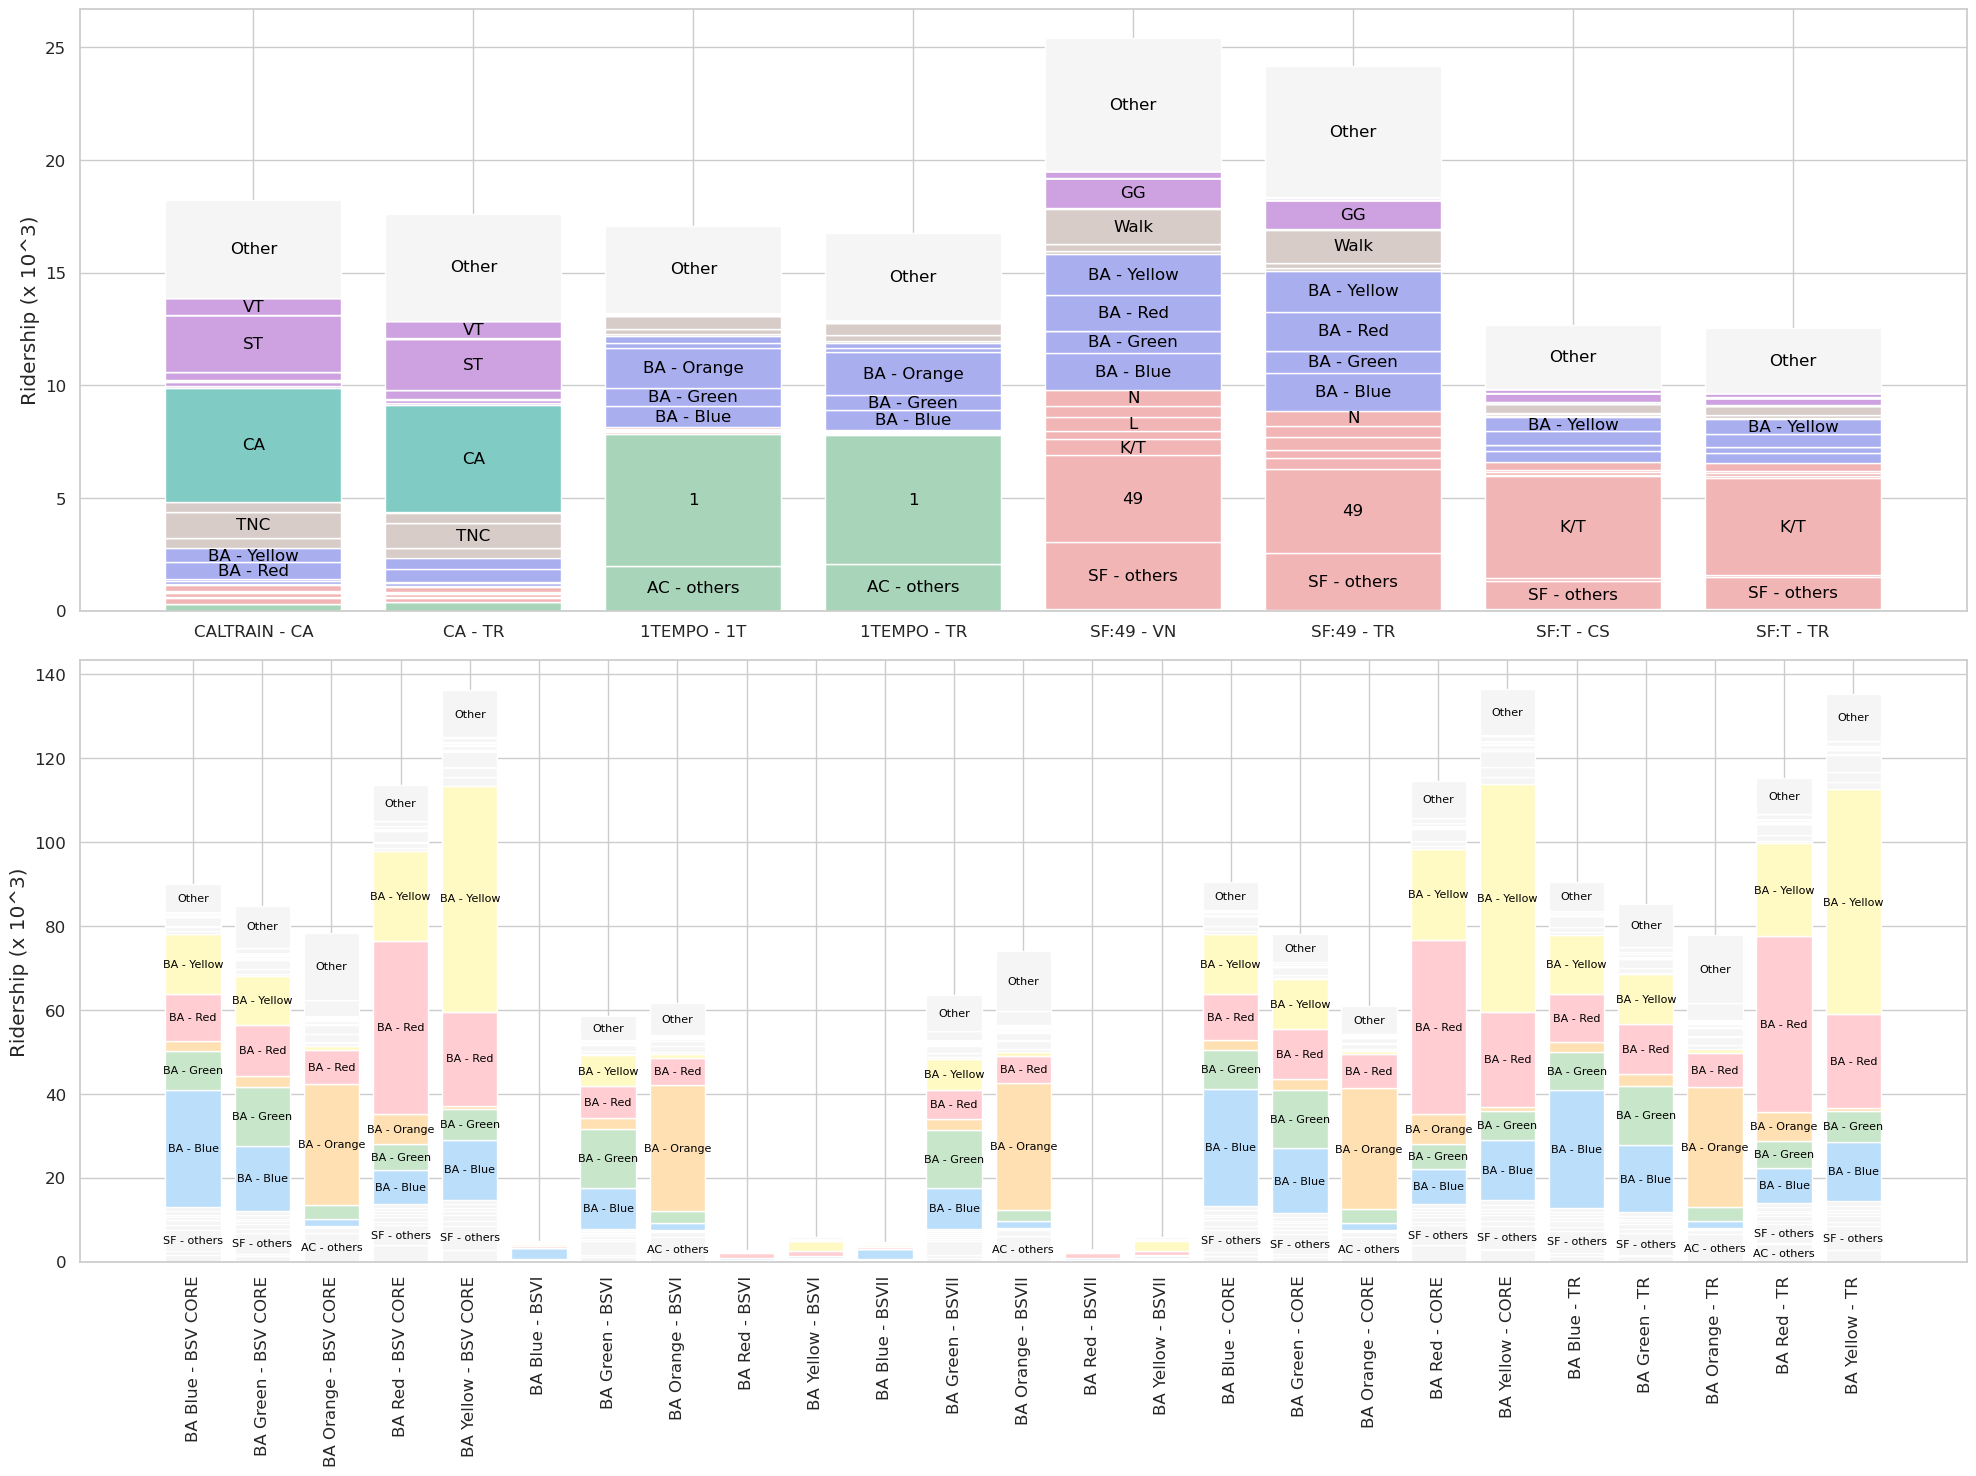

In [64]:
import matplotlib.pyplot as plt
import pandas as pd

def add_row_name_to_bars(ax, bottoms, values, column_names, row_name, threshold, fontsize):
    new_bottoms = [bottom + value for bottom, value in zip(bottoms, values)]
    for i, (bottom, new_bottom) in enumerate(zip(bottoms, new_bottoms)):
        mid_point = (bottom + new_bottom) / 2
        if (new_bottom - bottom) > threshold:  # Only add text if there's enough space
            ax.text(i, mid_point, row_name, ha='center', va='center', color='black', fontsize=fontsize)
    return new_bottoms

# Sample data preparation
# [Your data preparation code here, e.g., loading the df3 DataFrame]
df3 = FT3/1000
df3 = df3.drop("Total", axis=0)
# Color mapping for the first plot
color_mapping1= {
    '1': '#A8D5BA',        # Light Green
    'AC - others': '#A8D5BA',
    '49': '#F2B5B5',      # Light Red
    'K/T': '#F2B5B5',
    'J': '#F2B5B5',
    'L': '#F2B5B5',
    'M': '#F2B5B5',
    'N': '#F2B5B5',
    'SF - others': '#F2B5B5',
    'BART': '#A9AEEF',    # Light Blue
    'BA - Blue': '#A9AEEF',
    'BA - Green': '#A9AEEF',  # Pastel Green
    'BA - Orange': '#A9AEEF',  # Pastel Orange
    'BA - Red': '#A9AEEF',     # Pastel Red
    'BA - Yellow': '#A9AEEF',  # Pastel Yellow
    'Car': '#D7CCC8',         # Soft Red
    'CarPool': '#D7CCC8',     # Light Grey
    'TNC': '#D7CCC8',
    'TNC-Pool': '#D7CCC8',
    'Walk': '#D7CCC8',
    'Bike': '#D7CCC8',
    'CA': '#80CBC4',          # Soft Blue
    'AM': '#CEA2E1',         # Soft Purple
    'AY': '#CEA2E1',
    'CC': '#CEA2E1',
    'CE': '#CEA2E1',
    'CM': '#CEA2E1',
    'DE': '#CEA2E1',
    'EM': '#CEA2E1',
    'FF': '#CEA2E1',
    'GG': '#CEA2E1',
    'HF': '#CEA2E1',
    'MA': '#CEA2E1',
    'PE': '#CEA2E1',
    'RV': '#CEA2E1',
    'SB': '#CEA2E1',
    'SC': '#CEA2E1',
    'SL': '#CEA2E1',
    'SM': '#CEA2E1',
    'SO': '#CEA2E1',
    'SR': '#CEA2E1',
    'ST': '#CEA2E1',
    'TD': '#CEA2E1',
    'UC': '#CEA2E1',
    'VC': '#CEA2E1',
    'VN': '#CEA2E1',
    'VT': '#CEA2E1',
    'WC': '#CEA2E1',
    'WH': '#CEA2E1',
    'Other': '#F5F5F5'        # Light Grey
}
color_mapping2 = {
    '1': '#F5F5F5',  # muted dark green
    'AC - others': '#F5F5F5',
    '49': '#F5F5F5',  # muted dark red
    'K/T': '#F5F5F5',
    'J': '#F5F5F5',
    'L': '#F5F5F5',
    'M': '#F5F5F5',
    'N': '#F5F5F5',
    'SF - others': '#F5F5F5',
    'BART': '#F5F5F5',
    'BA - Blue': '#BBDEFB',  # muted blue
    'BA - Green': '#C8E6C9',  # muted green
    'BA - Orange': '#FFE0B2',  # muted orange
    'BA - Red': '#FFCDD2',  # muted red
    'BA - Yellow': '#FFF9C4',  # muted yellow
    'Car': '#F5F5F5',  # dark red
    'CarPool': '#F5F5F5',  # grey
    'TNC': '#F5F5F5',
    'TNC-Pool': '#F5F5F5',
    'Walk': '#F5F5F5',
    'Bike': '#F5F5F5',
    'CA': '#F5F5F5',  # muted dark blue
    'AM': '#F5F5F5',  # muted dark purple
    'AY': '#F5F5F5',
    'CC': '#F5F5F5',
    'CE': '#F5F5F5',
    'CM': '#F5F5F5',
    'DE': '#F5F5F5',
    'EM': '#F5F5F5',
    'FF': '#F5F5F5',
    'GG': '#F5F5F5',
    'HF': '#F5F5F5',
    'MA': '#F5F5F5',
    'PE': '#F5F5F5',
    'RV': '#F5F5F5',
    'SB': '#F5F5F5',
    'SC': '#F5F5F5',
    'SL': '#F5F5F5',
    'SM': '#F5F5F5',
    'SO': '#F5F5F5',
    'SR': '#F5F5F5',
    'ST': '#F5F5F5',
    'TD': '#F5F5F5',
    'UC': '#F5F5F5',
    'VC': '#F5F5F5',
    'VN': '#F5F5F5',
    'VT': '#F5F5F5',
    'WC': '#F5F5F5',
    'WH': '#F5F5F5',
    'Other': '#F5F5F5'  # grey
}
desired_order2 = [
    'AC - others', '1', 
    'SF - others', '49', 
    'K/T', 'J', 'L', 'M', 'N', 
    'BA - Blue', 'BA - Green', 'BA - Orange', 'BA - Red', 'BA - Yellow', 
    'Car', 'CarPool', 'TNC', 'TNC-Pool', 'Walk', 'Bike', 
    'CA',
    'AM', 'AY', 'CC', 'CE', 'CM', 'DE', 'EM', 'FF', 'GG', 'HF', 'MA', 'PE', 'RV', 'SB', 'SC', 
    'SL', 'SM', 'SO', 'SR', 'ST', 'TD', 'UC', 'VC', 'VN', 'VT', 'WC', 'WH',
    'Other'
]
desired_order1 = [
    'AC - others', '1', 
    'SF - others', '49', 
    'K/T', 'J', 'L', 'M', 'N', 
    'BA - Blue', 'BA - Green', 'BA - Orange', 'BA - Red', 'BA - Yellow', 
    'Car', 'CarPool', 'TNC', 'TNC-Pool', 'Walk', 'Bike', 
    'CA',
    'AM', 'AY', 'CC', 'CE', 'CM', 'DE', 'EM', 'FF', 'GG', 'HF', 'MA', 'PE', 'RV', 'SB', 'SC', 
    'SL', 'SM', 'SO', 'SR', 'ST', 'TD', 'UC', 'VC', 'VN', 'VT', 'WC', 'WH',
    'Other'
]

# Filter and reorder the rows for both plots
df_first_plot = df3.loc[desired_order1,['CALTRAIN - CA','CA - TR', '1TEMPO - 1T','1TEMPO - TR','SF:49 - VN','SF:49 - TR', 'SF:T - CS','SF:T - TR']]
df_second_plot = df3.loc[desired_order2,['BA Blue - BSV CORE', 'BA Green - BSV CORE', 'BA Orange - BSV CORE', 'BA Red - BSV CORE', 'BA Yellow - BSV CORE',
              'BA Blue - BSVI', 'BA Green - BSVI', 'BA Orange - BSVI', 'BA Red - BSVI', 'BA Yellow - BSVI',
              'BA Blue - BSVII', 'BA Green - BSVII', 'BA Orange - BSVII', 'BA Red - BSVII', 'BA Yellow - BSVII',
              'BA Blue - CORE', 'BA Green - CORE', 'BA Orange - CORE', 'BA Red - CORE', 'BA Yellow - CORE',
              'BA Blue - TR', 'BA Green - TR', 'BA Orange - TR', 'BA Red - TR', 'BA Yellow - TR']]

fig, axs = plt.subplots(2,1, figsize=(20, 15))

threshold1 = 2 * 0.3  # FOR TEXT
# Plotting the first graph
bottoms = [0] * len(df_first_plot.columns)
for row_name in df_first_plot.index:

    values = df_first_plot.loc[row_name]
    axs[0].bar(df_first_plot.columns, values, bottom=bottoms, color=color_mapping1[row_name], edgecolor='white')
    bottoms = add_row_name_to_bars(axs[0], bottoms, values, df_first_plot.columns, row_name, threshold1, fontsize = 12)


threshold2 = 2 * 2  # This is just an example value; adjust as needed
# Plotting the second graph
bottoms = [0] * len(df_second_plot.columns)
for row_name in df_second_plot.index:

    values = df_second_plot.loc[row_name]
    axs[1].bar(df_second_plot.columns, values, bottom=bottoms, color=color_mapping2[row_name], edgecolor='white')
    bottoms = add_row_name_to_bars(axs[1], bottoms, values, df_second_plot.columns, row_name, threshold2, fontsize = 8)



axs[0].set_xticks(range(len(df_first_plot.columns)))
axs[0].set_xticklabels(['CALTRAIN - CA','CA - TR', '1TEMPO - 1T','1TEMPO - TR','SF:49 - VN','SF:49 - TR', 'SF:T - CS','SF:T - TR'])

# Changing x labels for the second plot
axs[1].set_xticks(range(len(df_second_plot.columns)))
axs[1].set_xticklabels(['BA Blue - BSV CORE', 'BA Green - BSV CORE', 'BA Orange - BSV CORE', 'BA Red - BSV CORE', 'BA Yellow - BSV CORE',
              'BA Blue - BSVI', 'BA Green - BSVI', 'BA Orange - BSVI', 'BA Red - BSVI', 'BA Yellow - BSVI',
              'BA Blue - BSVII', 'BA Green - BSVII', 'BA Orange - BSVII', 'BA Red - BSVII', 'BA Yellow - BSVII',
              'BA Blue - CORE', 'BA Green - CORE', 'BA Orange - CORE', 'BA Red - CORE', 'BA Yellow - CORE',
              'BA Blue - TR', 'BA Green - TR', 'BA Orange - TR', 'BA Red - TR', 'BA Yellow - TR'])

axs[0].set_xticks(range(len(df_first_plot.columns)))
axs[0].set_xticklabels(['CALTRAIN - CA','CA - TR', '1TEMPO - 1T','1TEMPO - TR','SF:49 - VN','SF:49 - TR', 'SF:T - CS','SF:T - TR'])

# Changing x labels for the second plot
axs[1].set_xticks(range(len(df_second_plot.columns)))
axs[1].set_xticklabels(['BA Blue - BSV CORE', 'BA Green - BSV CORE', 'BA Orange - BSV CORE', 'BA Red - BSV CORE', 'BA Yellow - BSV CORE',
              'BA Blue - BSVI', 'BA Green - BSVI', 'BA Orange - BSVI', 'BA Red - BSVI', 'BA Yellow - BSVI',
              'BA Blue - BSVII', 'BA Green - BSVII', 'BA Orange - BSVII', 'BA Red - BSVII', 'BA Yellow - BSVII',
              'BA Blue - CORE', 'BA Green - CORE', 'BA Orange - CORE', 'BA Red - CORE', 'BA Yellow - CORE',
              'BA Blue - TR', 'BA Green - TR', 'BA Orange - TR', 'BA Red - TR', 'BA Yellow - TR'],rotation=90)

axs[0].set_ylabel('Ridership (x 10^3)')
axs[1].set_ylabel('Ridership (x 10^3)')

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
# plt.show()

plt.savefig('stacked_bar_chart_high_quality.png', dpi=1200)


# ***OTHER PLOTS***

In [16]:
# Inexus_names_dict = {'logsum_trip_Potential_INEXUS':'Potenzial Inexus',
#                                                    # 'destination_logsum_x','destination_logsum_y','logsum_tours_mode_AS_tours','workplace_location_logsum',
#                                                'person_id':'Person ID', 
#                                                'duration_travelling':'Duration Travelling','distance_travelling':'Distance Travelling', 'duration_door_to_door':'Duration Door to Door',
#                                               'actStartTime':'Activity Start Time', 'actEndTime':'Activity End Time', 'actPurpose':'Activity Purpose', 
#                                                'cost_BEAM':'Cost BEAM',
#                                                'duration_walking':'Duration Walking','duration_in_privateCar':'Duration Private Car','duration_on_bike':'Duration Bike',
#                                                'duration_in_ridehail':'Duration Ridehail','duration_in_transit':'Duration in Transit','distance_travelling':'Distance Travelling','distance_walking':'Distance Walking',
#                                                'distance_bike':'Distance Bike','distance_ridehail':'Distance Rifdehail','distance_privateCar':'Distance Private Car','distance_transit':'Distance Transit',
#                                               'mode_choice_planned_BEAM':'Mode Choice Planned','mode_choice_actual_BEAM':'Mode Choice Actual','mode_choice_actual_4':'Mode Choice Actual 4','mode_choice_actual_5':'Mode Choice Actual 5','mode_choice_actual_6':'Mode Choice Actual 6',
#                                                'distance_mode_choice':'Distance Mode Choice',  'vehicleIds':'Vehicle IDs', 'replanning_status':'Replanning Status', 'reason':'Reason Replanning',
#                                                'fuelElectricity':'Fuel Electricity','fuelDiesel':'Fuel Diesel', 'fuelGasoline':'Fuel Gasoline', 'fuel_marginal':'Fuel Marginal',  
#                                                'emissionElectricity':'Emission Electricity','emissionDiesel':'Emission Diesel', 'emissionGasoline':'Emission Gasoline', 'emission_marginal':'Emission Marginal', }

grouped_sum = df.groupby('Project Tried').agg({
    'Distance Travelling INEXUS Baseline': 'sum',
    'Duration Travelling INEXUS Baseline': 'sum',
    'Potenzial Inexus INEXUS Baseline': 'sum',
    'Distance Travelling INEXUS TR': 'sum',
    'Duration Travelling INEXUS TR': 'sum',
    'Potenzial Inexus INEXUS TR': 'sum'
}).reset_index()

# Calculate averages for each 'Switch From' condition for "Baseline" and "TR"
conditions = [
    'Switch from another transit agency',
    'Switch from same transit agency',
    'Switch from another mode'
]
# avg_incomes_baseline = [df[df['Switch From'] == condition]['Person Income'].mean() for condition in conditions]
# avg_incomes_TR = [df[df['Switch From'] == condition]['Person Income'].mean() for condition in conditions]

# # Display results in a table format
# average_income_df = pd.DataFrame({
#     'Switch From': conditions,
#     'Average Household Income': avg_incomes_baseline,
#     'Average Household Income': avg_incomes_TR
# })

# Printing the results
print("Grouped Sums:")
print(grouped_sum)

print("\nAverage Household Incomes:")
# print(average_income_df*4160)

Grouped Sums:
      Project Tried  Distance Travelling INEXUS Baseline  \
0       1TEMPO - 1T                         4.734377e+07   
1       1TEMPO - TR                         4.755609e+07   
2   BART - BSV CORE                         1.836480e+09   
3       BART - BSVI                         5.159376e+08   
4      BART - BSVII                         5.852603e+08   
5       BART - CORE                         1.729946e+09   
6         BART - TR                         1.832985e+09   
7           CA - TR                         1.212279e+08   
8     CALTRAIN - CA                         1.274505e+08   
9        SF:49 - TR                         4.325386e+07   
10       SF:49 - VN                         4.551706e+07   
11        SF:T - CS                         2.870143e+07   
12        SF:T - TR                         2.940010e+07   

    Duration Travelling INEXUS Baseline  Potenzial Inexus INEXUS Baseline  \
0                             7941963.0                      -5364.7

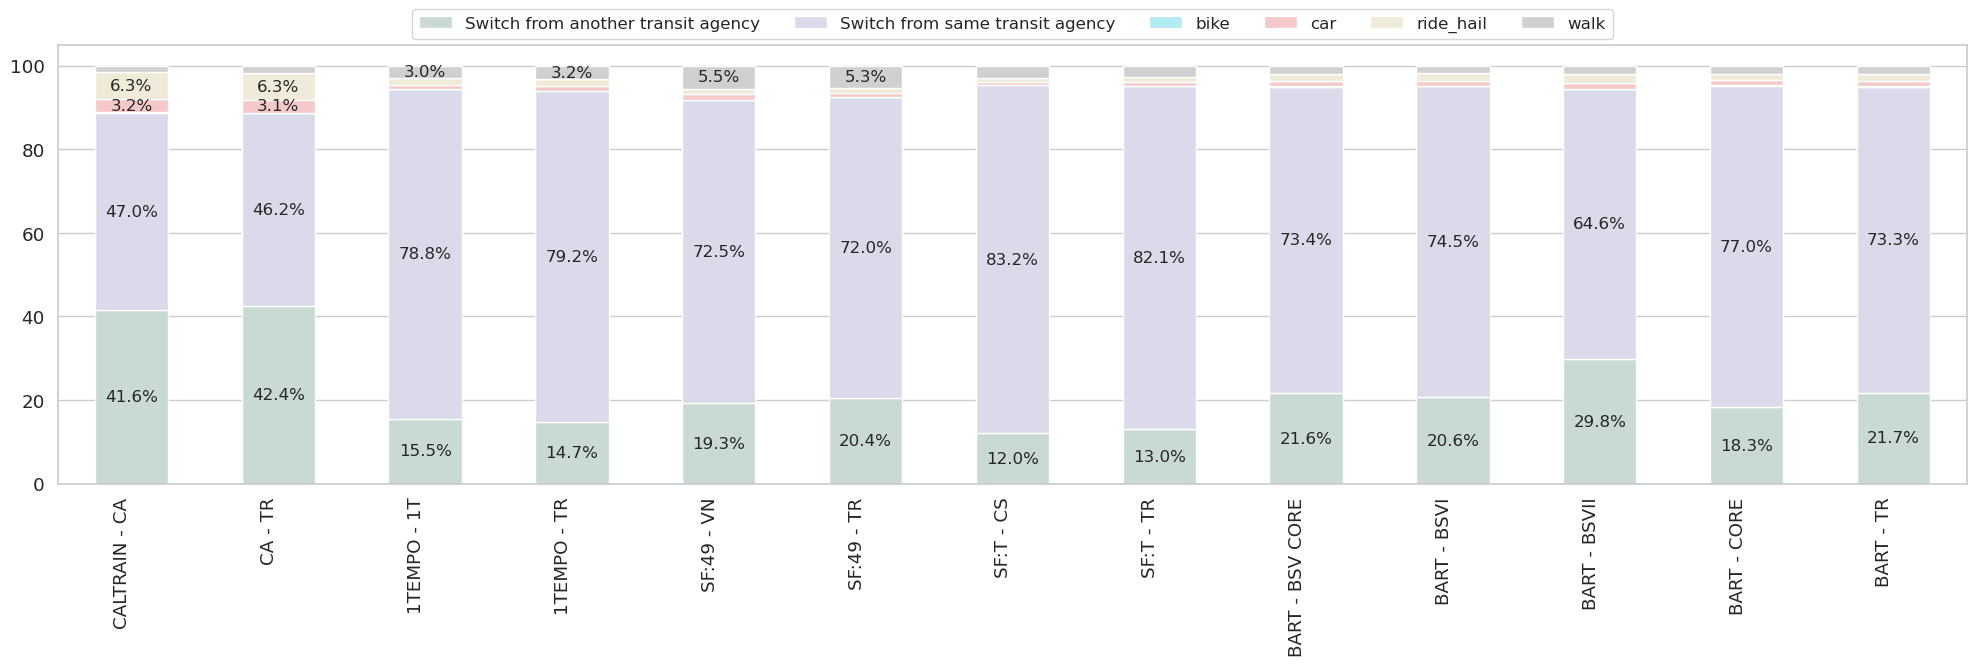

In [84]:
# Define the mapping for aggregation
mapping = {
    'car': 'Car',
    'car_hov2': 'Car',
    'car_hov3': 'Car',
    'ride_hail': 'TNC',
    'ride_hail_pooled': 'TNC',
    'bike': 'Bike',
    'walk': 'Walk',
    'walk_transit': 'Walk',
    'drive_transit': 'Car'
}
project_name_mapping = {
    "AC - 1TEMPO": "1Tempo BRT",
    "BA - Extension and Core project": "BART",
    "CA - Electrification Project": "Caltrain",
    "SF - Central Subway": "Central Subway",
    "SF - Van Ness": "Van Ness BRT"
}

# Apply the mapping to 'Chosen Mode Baseline' column
df['Chosen Mode Baseline'] = df['Chosen Mode Baseline'].replace(mapping)
df['Project Tried'] = df['Project Tried'].replace(project_name_mapping)

# Remove rows with 'walk_transit' in 'Chosen Mode Baseline'
# df = df[df['Chosen Mode Baseline'] != 'walk_transit']

# 1. Generate the two color palettes: one blue and one orange.
custom_palette = [
    '#c9d9d3',  # very light green
    '#dadaeb',  # very light purple
    '#b2ebf2',
    '#f5c9c9',
    '#f0ebd8',  # very light yellow
    '#d0d0d0',   # another light grey
    '#e3dfd5',  # off white/greyish
    '#d9d9d9',  # light grey
]
# custom_palette.extend([
#     '#90caf9',  # medium-light blue
#     '#ffcc80',  # light orange
#     '#64b5f6',  # medium blue
#     '#ffa726',  # medium orange
#     '#42a5f5',  # darker blue
#     '#fb8c00'   # darker orange
# ])

# Ensure the palette has enough colors for the data
if len(custom_palette) < grouped_df.shape[1]:
    custom_palette = sns.color_palette("husl", n_colors=grouped_df.shape[1])  # Fallback to a diverse palette

colors = {col: custom_palette[i] for i, col in enumerate(grouped_df.columns)}

# Group by 'Project Tried' and 'Switch From', then count occurrences
grouped_df = df.groupby(['Project Tried', 'Switch From']).size().unstack(fill_value=0)

# Extract the rows in df where 'Switch From' is 'Switch from another mode'
switch_rows = df[df['Switch From'] == 'Switch from another mode']

# Group by 'Project Tried' and 'Chosen Mode Baseline' to get the count of each mode
switch_mode_grouped = switch_rows.groupby(['Project Tried', 'Mode Choice Actual 5 INEXUS Baseline']).size().unstack(fill_value=0)

# Replace the 'Switch from another mode' column in grouped_df with the columns from switch_mode_grouped
grouped_df = grouped_df.drop(columns='Switch from another mode')
grouped_df = pd.concat([grouped_df, switch_mode_grouped], axis=1, sort=False).fillna(0)

# Create a new DataFrame with normalized percentages
# normalized_df = grouped_df.div(grouped_df.sum(axis=1), axis=0) * 100

# Reorder the rows (i.e., the projects)
ordered_projects = ['CALTRAIN - CA','CA - TR', '1TEMPO - 1T','1TEMPO - TR','SF:49 - VN','SF:49 - TR', 'SF:T - CS','SF:T - TR', 'BART - BSV CORE','BART - BSVI', 'BART - BSVII', 'BART - CORE', 'BART - TR',  ]
grouped_df = grouped_df.loc[ordered_projects]

# Create a new DataFrame with normalized percentages
normalized_df = grouped_df.div(grouped_df.sum(axis=1), axis=0) * 100

# Plot with the custom color palette
ax = normalized_df.plot(kind='bar', stacked=True, figsize=(20, 7), color=custom_palette)



# Set plot labels and title
# plt.xlabel('Project')
# plt.ylabel('Percentage (%)', fontsize=18)
# plt.title('Percentage of "Switch From" for each project')
# plt.legend(title='Switch From', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-labels for better readability
plt.xticks( ha='right')

ax.legend( bbox_to_anchor=(0.5, 1.1), loc='upper center', ncol=len(normalized_df.columns), fontsize = 12)

# Add labels on each stacked bar
threshold = 3  # for example, only show numbers if the segment represents more than 5%

# Adjust bar labeling
cumulative_heights = [0] * len(normalized_df)

for container in ax.containers:
    for i, rect in enumerate(container):
        height = rect.get_height()
        x_pos = rect.get_x() + rect.get_width() / 2.
        y_pos = cumulative_heights[i] + height / 2.
        
        cumulative_heights[i] += height  # Update the cumulative height
        
        # Only label if above the threshold and height is not zero
        if height > threshold and height != 0:
            ax.text(x_pos, y_pos, f"{height:.1f}%", ha='center', va='center', fontsize=12)
            
# ax.set_xticks(range(len(df.columns)))
# ax.set_xticklabels(['Caltrain','1Tempo BRT', 'Van Ness BRT',   'Central Subway','BART'], rotation=0, fontsize=18,ha='center')
ax.set_xlabel("")
# ax.set_xticks([r + rect.get_width() / 2 for r in range(len(normalized_df))])  # Adjust the x-tick positions

ax.xaxis.grid(False)
# Adjust layout to fit everything nicely
plt.tight_layout()
plt.savefig('switch from.png', dpi=1200)

# Show the plot
plt.show()

In [19]:
Inexus_names_dict = {'logsum_trip_Potential_INEXUS':'Potenzial Inexus',
                                                   # 'destination_logsum_x','destination_logsum_y','logsum_tours_mode_AS_tours','workplace_location_logsum',
                                               'person_id':'Person ID', 
                                               'duration_travelling':'Duration Travelling','distance_travelling':'Distance Travelling', 'duration_door_to_door':'Duration Door to Door',
                                              'actStartTime':'Activity Start Time', 'actEndTime':'Activity End Time', 'actPurpose':'Activity Purpose', 
                                               'cost_BEAM':'Cost BEAM',
                                               'duration_walking':'Duration Walking','duration_in_privateCar':'Duration Private Car','duration_on_bike':'Duration Bike',
                                               'duration_in_ridehail':'Duration Ridehail','duration_in_transit':'Duration in Transit','distance_travelling':'Distance Travelling','distance_walking':'Distance Walking',
                                               'distance_bike':'Distance Bike','distance_ridehail':'Distance Rifdehail','distance_privateCar':'Distance Private Car','distance_transit':'Distance Transit',
                                              'mode_choice_planned_BEAM':'Mode Choice Planned','mode_choice_actual_BEAM':'Mode Choice Actual','mode_choice_actual_4':'Mode Choice Actual 4','mode_choice_actual_5':'Mode Choice Actual 5','mode_choice_actual_6':'Mode Choice Actual 6',
                                               'distance_mode_choice':'Distance Mode Choice',  'vehicleIds':'Vehicle IDs', 'replanning_status':'Replanning Status', 'reason':'Reason Replanning',
                                               'fuelElectricity':'Fuel Electricity','fuelDiesel':'Fuel Diesel', 'fuelGasoline':'Fuel Gasoline', 'fuel_marginal':'Fuel Marginal',  
                                               'emissionElectricity':'Emission Electricity','emissionDiesel':'Emission Diesel', 'emissionGasoline':'Emission Gasoline', 'emission_marginal':'Emission Marginal', }
diff_variables = ['logsum_trip_Potential_INEXUS',
                                               'duration_travelling','distance_travelling', 'duration_door_to_door',
                                              'actStartTime', 'actEndTime',
                                               'cost_BEAM',
                                               'duration_walking','duration_in_privateCar','duration_on_bike',
                                               'duration_in_ridehail','distance_travelling','duration_in_transit','distance_walking',
                                               'distance_bike','distance_ridehail','distance_privateCar','distance_transit',
                                               'distance_mode_choice',  
                                               'fuelElectricity','fuelDiesel', 'fuelGasoline', 'fuel_marginal',  
                                               'emissionElectricity','emissionDiesel', 'emissionGasoline', 'emission_marginal', ]

for var, name in zip(Inexus_names_dict.keys(), Inexus_names_dict.values()):
                        baseline_col_name = f'{name} INEXUS Baseline'
                        TR_col_name = f'{name} INEXUS TR'
                        # Calculate absolute difference if variable is in diff_variables
                        if var in diff_variables:
                            diff_col_name = f'{name} INEXUS Diff'
                            df[diff_col_name] = df[TR_col_name] - df[baseline_col_name]

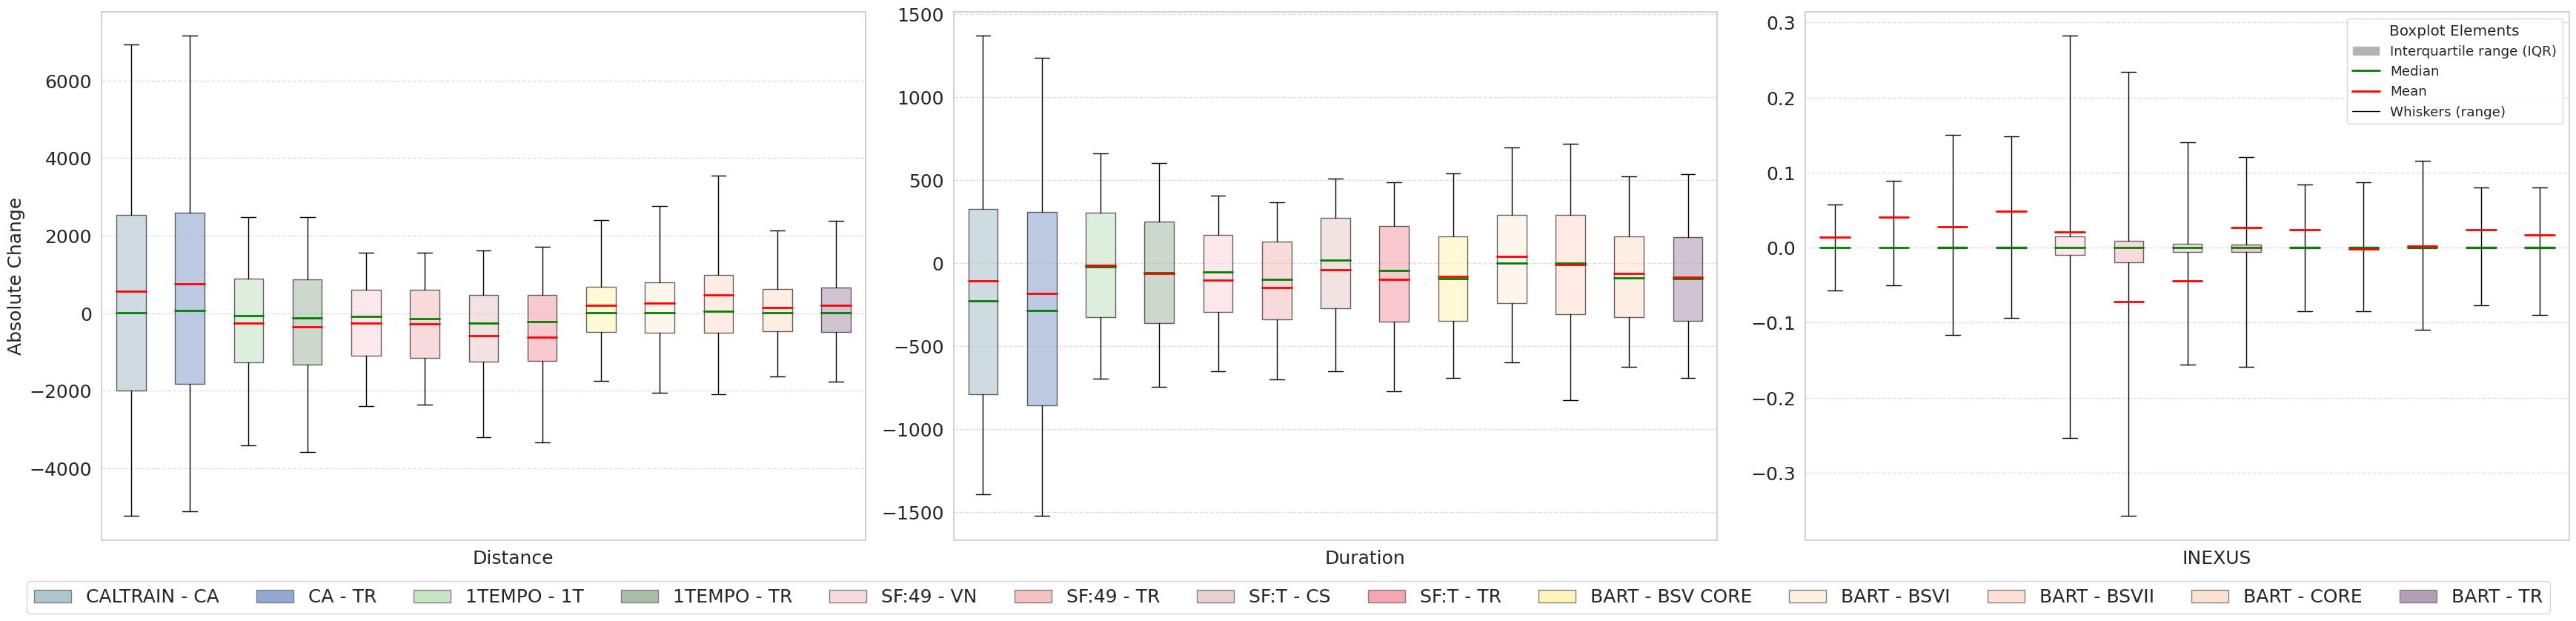

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

pastel_palette = [
    # Blue shades
    '#AEC6CF',  # Pastel Blue
    '#92A8D1',  # Soft Cornflower Blue

    # Green shades
    '#C8E4C5',  # Pastel Green
    '#A9BEA9',  # Soft Moss Green

    # Pink & Red shades
    '#FADADD',  # Pastel Pink
    '#F4C2C2',  # Baby Pink

    '#ECCFCF',  # Pastel Red
    '#F6A6B2',  # Soft Coral

    # Yellow & Peach shades
    '#FFF5BA',  # Pastel Yellow
    '#FEF1E1',  # Soft Sun Glow

    '#FFDFD3',  # Pastel Peach
    '#FDE1D1',  # Soft Peach

    # Purple & Lavender shades
    '#B39EB5',  # Pastel Purple
    '#DCC6E0',  # Soft Lavender

    # Aqua & Mint shades
    '#BFD8D2',  # Pastel Aqua
    '#A2D5C6',  # Soft Seafoam

    # Beige & Grey shades
    '#ECEABE',  # Pastel Beige
    '#CFD8DC',  # Soft Light Grey
]
# sns.husl_palette(16, l=.7, s=.8) # Increase lightness and saturation for pastel


# Set overall aesthetics
sns.set_context("talk")
sns.set(font_scale=1.2, style="whitegrid")

# Create 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=(35, 8))

# Variables to plot
metrics = ['Distance Travelling INEXUS Diff', 'Duration Travelling INEXUS Diff', 'Potenzial Inexus INEXUS Diff']
projects = ['CALTRAIN - CA','CA - TR', '1TEMPO - 1T','1TEMPO - TR','SF:49 - VN','SF:49 - TR', 'SF:T - CS','SF:T - TR', 'BART - BSV CORE','BART - BSVI', 'BART - BSVII', 'BART - CORE', 'BART - TR',  ]
n_projects = len(projects)
labels = ['Distance', 'Duration', 'INEXUS']

mean_line_props = dict(linestyle='-', linewidth=2, color='red')
median_line_props = dict(linestyle='-', linewidth=2, color='green')

for i, (ax, metric) in enumerate(zip(axes, metrics)):
    for j, project in enumerate(projects):
        if metric == 'Potenzial Inexus INEXUS Diff':
            subset = df[df['Project Tried'] == project]
            ax.boxplot(subset[metric]*11.23, positions=[j], widths=0.5, patch_artist=True, showfliers=False, 
                       boxprops=dict(facecolor=pastel_palette[j], alpha=0.6), 
                       whis=[10, 90],  # Display whiskers for 5th and 95th percentiles
                       showmeans=True,  # Display the mean
                       meanline=True,  # Show the mean as a line
                       meanprops=mean_line_props,  # Custom properties for mean line
                       medianprops=median_line_props)  # Custom properties for median line
        else:
            subset = df[df['Project Tried'] == project]
            ax.boxplot(subset[metric], positions=[j], widths=0.5, patch_artist=True, showfliers=False, 
                       boxprops=dict(facecolor=pastel_palette[j], alpha=0.6),
                       whis=[10, 90],  # Display whiskers for 5th and 95th percentiles
                       showmeans=True,  # Display the mean
                       meanline=True,  # Show the mean as a line
                       meanprops=mean_line_props,  # Custom properties for mean line
                       medianprops=median_line_props)  # Custom properties for median line

    
    # Setting y-label for each subplot
    if i ==0:
        ax.set_ylabel(f'Absolute Change', fontsize=18)
    
    # X-axis settings
    ax.set_xticks([n_projects/2])  # centering the metric name
    ax.set_xticklabels([labels[i]], fontsize=18)  # using the first word of the metric name, and setting fontsize to 18
    ax.xaxis.grid(False)  # <-- Set visible to False
    ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=.25)
    ax.tick_params(axis='both', which='major', labelsize=18)  # setting the tick font size to 18

# Global title
# fig.suptitle('Absolute Change and Distribution from Baseline', fontsize=18, y=1.08)

# Global legend within the plots, horizontally over the plots
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=pastel_palette[i], edgecolor='gray', label=project) 
                   for i, project in enumerate(projects)]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=len(projects), fontsize=18)

legend_elements = [
    Patch(facecolor='gray', alpha=0.6, label='Interquartile range (IQR)'),
    Line2D([0], [0], linestyle='-', linewidth=2, color='green', label='Median'),
    Line2D([0], [0], linestyle='-', linewidth=2, color='red', label='Mean'),
    Line2D([0], [0], linestyle='-', linewidth=1, color='black', label='Whiskers (range)'),
]

# Assuming you want to add the legend to the last subplot for clarity
ax = axes[-1]
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1), title="Boxplot Elements")



plt.tight_layout()
plt.savefig('column_plot_distribution.png', dpi=600, bbox_inches='tight')
plt.show()


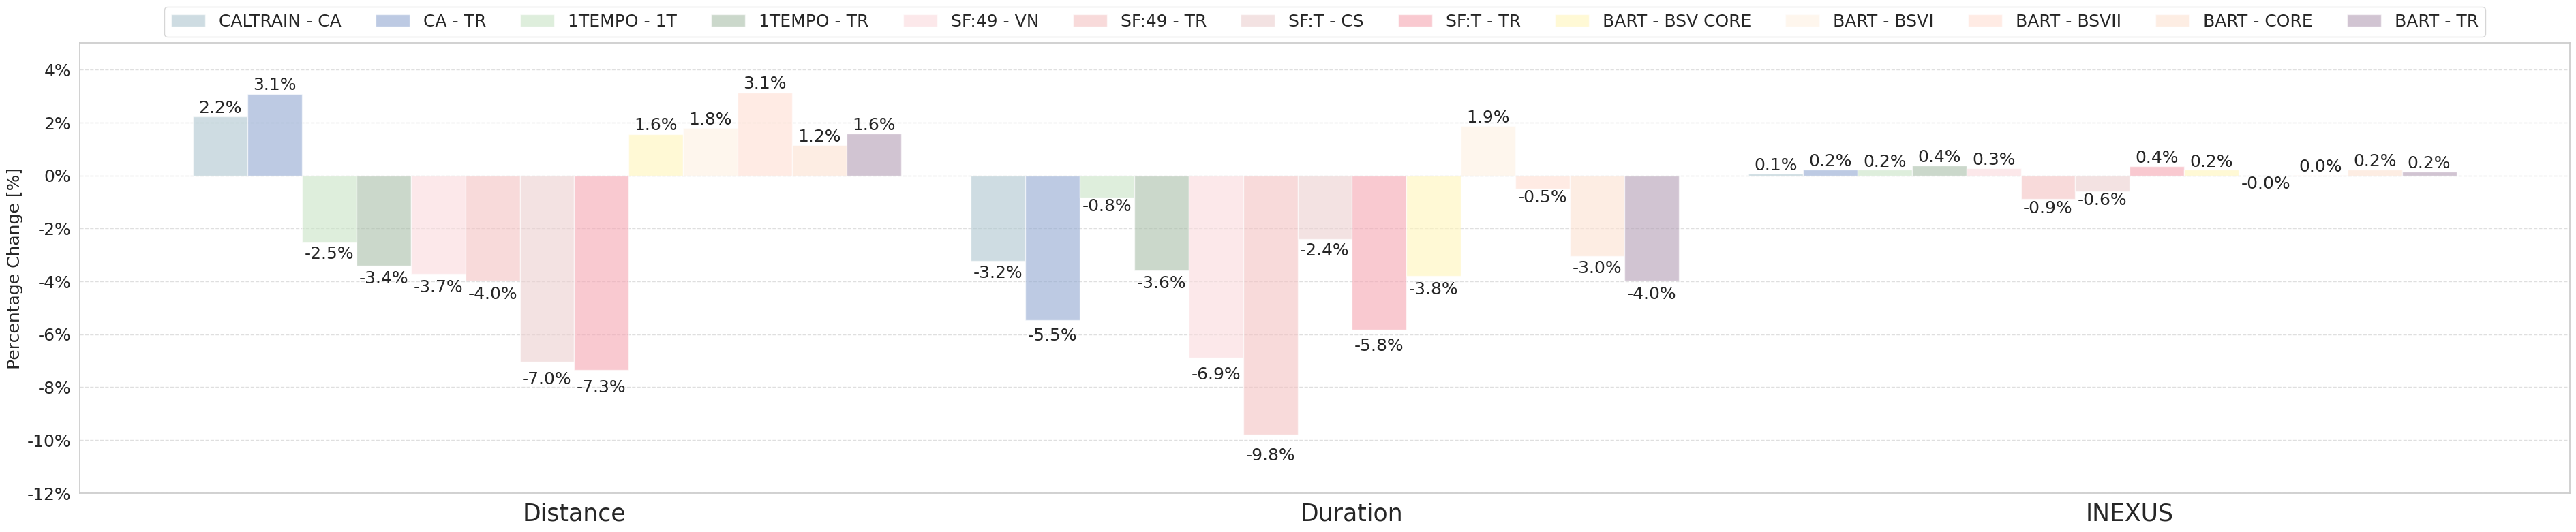

In [109]:
metrics = ['Distance','Duration','INEXUS']
metrics_bs = metrics = ['Distance Travelling INEXUS Baseline', 'Duration Travelling INEXUS Baseline', 'Potenzial Inexus INEXUS Baseline']
metrics_tr = metrics = ['Distance Travelling INEXUS TR', 'Duration Travelling INEXUS TR', 'Potenzial Inexus INEXUS TR']
labels = ['Distance', 'Duration', 'INEXUS']

pastel_palette = [
    # Blue shades
    '#AEC6CF',  # Pastel Blue
    '#92A8D1',  # Soft Cornflower Blue

    # Green shades
    '#C8E4C5',  # Pastel Green
    '#A9BEA9',  # Soft Moss Green

    # Pink & Red shades
    '#FADADD',  # Pastel Pink
    '#F4C2C2',  # Baby Pink

    '#ECCFCF',  # Pastel Red
    '#F6A6B2',  # Soft Coral

    # Yellow & Peach shades
    '#FFF5BA',  # Pastel Yellow
    '#FEF1E1',  # Soft Sun Glow

    '#FFDFD3',  # Pastel Peach
    '#FDE1D1',  # Soft Peach

    # Purple & Lavender shades
    '#B39EB5',  # Pastel Purple
    '#DCC6E0',  # Soft Lavender

    # Aqua & Mint shades
    '#BFD8D2',  # Pastel Aqua
    '#A2D5C6',  # Soft Seafoam

    # Beige & Grey shades
    '#ECEABE',  # Pastel Beige
    '#CFD8DC',  # Soft Light Grey
]

# Calculate percentage change for each metric and project
percentage_changes = {}

for mb, mt, m in zip(metrics_bs, metrics_tr, metrics):
    percentage_changes[m] = []
    for project in projects:
        
        
        baseline_sum = df[df['Project Tried'] == project][mb].sum()
        tr_sum = df[df['Project Tried'] == project][mt].sum()

        change = 100 * (tr_sum - baseline_sum) / abs(baseline_sum)  # percentage change formula
        percentage_changes[m].append(change)


# Plotting
# Assuming the percentage change for each metric and project is already calculated as per previous code in `percentage_changes`
# We will adjust the plotting structure:

fig, ax = plt.subplots(figsize=(40, 8))
width = 0.07  # adjust as needed
ind = np.arange(len(metrics))  # the x locations for the metrics

# Loop to plot bars for each project under each metric
for i, project in enumerate(projects):
    
    values = [percentage_changes[metric][i]  if metric != 'INEXUS' else -percentage_changes[metric][i] for metric in metrics ]


    bars = ax.bar(ind + i*width, values, width, color=pastel_palette[i], label=project, alpha=0.6)
    
    
    # Adding values on top or below the bars based on value's sign
    for bar in bars:
        height = bar.get_height()
        if height >= 0:
            ax.text(bar.get_x() + bar.get_width()/2., 1.01*height, f'{height:.1f}%', 
                    ha='center', va='bottom', fontsize=18)
        else:
            ax.text(bar.get_x() + bar.get_width()/2., 1.05*height, f'{height:.1f}%', 
                    ha='center', va='top', fontsize=18)

# Adjust x-axis labels and other aesthetics
ax.set_ylabel('Percentage Change [%]', fontsize=18)
# Define a custom formatter function
def percent_formatter(x, pos):
    return f"{int(x)}%"

# Assuming 'ax' is your Axes object
ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
ax.tick_params(axis='y', labelsize=18)  # Adjust the number to your preferred font size for the y-axis
ax.set_xticks(ind + width * (len(projects) / 2))
ax.set_xticklabels(labels, fontsize=25)
# Put the legend inside the graph, the loc parameter can be adjusted to place the legend at a different position
ax.legend(fontsize=18, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=13)  # Adjust 'ncol' as needed
ax.grid(True, axis='y', linestyle='--', which='major', color='gray', alpha=.25)
ax.set_ylim(-12, 5)# Adjust the upper limit as necessary
plt.tight_layout()
ax.xaxis.grid(False)
plt.savefig('percentage_change_grouped3.png', dpi=600, bbox_inches='tight')
plt.show()



In [29]:
 df['Person Race'].value_counts()

White alone                                         257691
Asian alone                                         135992
Black or African American alone                      47263
Some Other Race alone                                40476
Two or More Races                                    24603
Native Hawaiian and Other Pacific Islander alone      2615
American Indian alone                                 2125
Alaska Native alone                                     51
Name: Person Race, dtype: int64

Project Tried
CALTRAIN - CA      49822.914673
CA - TR            49364.436966
1TEMPO - 1T        20382.012275
1TEMPO - TR        20565.333851
SF:49 - VN         51632.560344
SF:49 - TR         51636.851124
SF:T - CS          39218.163793
SF:T - TR          39161.973913
BART - BSV CORE    42505.936653
BART - BSVI        36907.553410
BART - BSVII       36063.271190
BART - CORE        43344.020520
BART - TR          42516.713667
Name: Person Income, dtype: float64


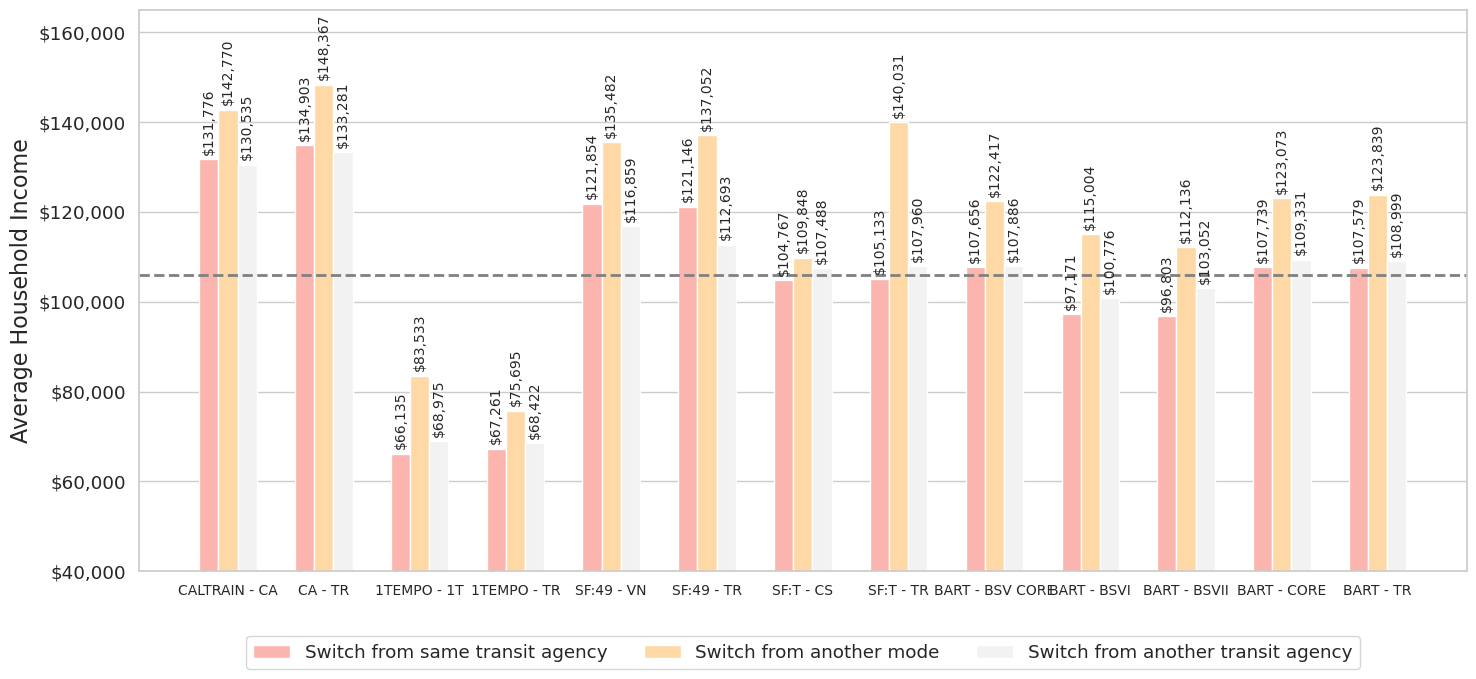

In [112]:
import numpy as np

df = df[df['Person Race']!='American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other races']
dfx = df[df['HS Income']>0]
# Compute the average income per project
# avg_income_per_project = dfx.groupby('Project Tried')['HS Income'].mean()
avg_income_per_project_switch_test = dfx.pivot_table(values='HS Income', index='Project Tried', columns='Switch From', aggfunc='mean')


ordered_projects = ['CALTRAIN - CA','CA - TR', '1TEMPO - 1T','1TEMPO - TR','SF:49 - VN','SF:49 - TR', 'SF:T - CS','SF:T - TR', 'BART - BSV CORE','BART - BSVI', 'BART - BSVII', 'BART - CORE', 'BART - TR',  ]

# Order the dataframes according to the specified order of projects
avg_income_per_project_switch_test = avg_income_per_project_switch_test.loc[ordered_projects]
print(avg_income_per_project)

fig, ax1 = plt.subplots(figsize=(15, 7))

# Bar width for grouped bars
bar_width = 0.2
switch_categories = df['Switch From'].unique()
num_switches = len(switch_categories)
positions = list(range(len(ordered_projects)))

# Pastel1 palette
colors = plt.cm.Pastel1(np.linspace(0, 1, num_switches))

for index, (switch, color) in enumerate(zip(switch_categories, colors)):
    switch_values = avg_income_per_project_switch_test[switch]
    ax1.bar([pos + index * bar_width for pos in positions], switch_values, width=bar_width, label=switch, color=color)

# Annotate bars with their values
for index, project in enumerate(ordered_projects):
    for switch_index, switch in enumerate(switch_categories):
        value = avg_income_per_project_switch_test.at[project, switch]
        ax1.text(index + switch_index * bar_width, value + 1000, f'${value:,.0f}', ha='center', va='bottom', fontsize=10, rotation = 90)

# Adjust x-axis to accommodate grouped bars
ax1.set_xticks([pos + bar_width for pos in positions])
ax1.set_xticklabels(ordered_projects, rotation=0, fontsize=10)

# Overall average line, legend placement and formatting
ax1.axhline(y=105854, color='gray', linestyle='--', linewidth=2)
ax1.legend( loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(switch_categories))  # Adjusted these parameters
ax1.set_ylabel('Average Household Income', fontsize=16)
ax1.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
ax1.xaxis.grid(False)
ax1.set_ylim(40000, 165000)# Adjust the upper limit as necessary

plt.tight_layout()
plt.savefig('average_income_grouped.png', dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
grouped = df.groupby('Project Tried')

vmt_baseline = grouped['Trip Length Baseline'].sum()
vmt_TR = grouped['Trip Length TR'].sum()

vht_baseline = grouped['Trip Duration Baseline'].sum()
vht_TR = grouped['Trip Duration TR'].sum()

plan_mode_baseline = grouped['Planned Mode Baseline'].value_counts()
plan_mode_TR = grouped['Planned Mode TR'].value_counts()

mode_baseline = grouped['Chosen Mode Baseline'].value_counts()
mode_TR = grouped['Chosen Mode TR'].value_counts()

inexus_baseline = grouped['Potential INEXUS Baseline'].sum()
inexus_TR = grouped['Potential INEXUS TR'].sum()


In [ ]:
vmt_baseline

In [ ]:
vmt_TR

In [ ]:
vht_baseline

In [ ]:
vht_TR

In [ ]:
plan_mode_baseline

In [ ]:
plan_mode_TR

In [ ]:
mode_baseline

In [ ]:
mode_TR

In [ ]:
inexus_baseline

In [ ]:
inexus_TR

In [ ]:
TR = inexus_TR
BS = inexus_baseline

index_union = BS.index.union(TR.index)
baseline_reindexed = BS.reindex(index_union, fill_value=0)
TR_reindexed = TR.reindex(index_union, fill_value=0)

# Calculate the difference between the two reindexed pivot tables
difference_table = (TR_reindexed - baseline_reindexed)/(-baseline_reindexed)*100

# The `difference_table` will contain the differences between the two original pivot tables.
print(difference_table)

In [ ]:
TR = mode_TR
BS = mode_baseline

index_union = BS.index.union(TR.index)
baseline_reindexed = BS.reindex(index_union, fill_value=0)
TR_reindexed = TR.reindex(index_union, fill_value=0)

# Calculate the difference between the two reindexed pivot tables
difference_table = TR_reindexed - baseline_reindexed 

# The `difference_table` will contain the differences between the two original pivot tables.
print(difference_table)

# ***EVENTS STATS PUBLIC TRANSIT***

In [ ]:
dataFilepath_sim = [
        'gs://beam-core-outputs/sfbay-baseline2018-30pct-20230825/beam/year-2018-iteration-10/ITERS/it.0/0.events.csv.gz',
        'gs://beam-core-outputs/sfbay-tr-30pct-20231014/beam/year-2018-iteration-10/ITERS/it.0/0.events.csv.gz',
        'gs://beam-core-outputs/sfbay-tr-BARTBSV-30pct-20230825/beam/year-2018-iteration-10/ITERS/it.0/0.events.csv.gz',
        'gs://beam-core-outputs/sfbay-tr-BARTBSVI-30pct-20230828/beam/year-2018-iteration-10/ITERS/it.0/0.events.csv.gz',
        'gs://beam-core-outputs/sfbay-tr-BARTBSVII-30pct-20230828/beam/year-2018-iteration-10/ITERS/it.0/0.events.csv.gz',
        'gs://beam-core-outputs/sfbay-tr-BARTCORE-30pct-20230828/beam/year-2018-iteration-10/ITERS/it.0/0.events.csv.gz',
        'gs://beam-core-outputs/sfbay-tr-TempoBRT-30pct-20230825/beam/year-2018-iteration-10/ITERS/it.0/0.events.csv.gz',
        'gs://beam-core-outputs/sfbay-tr-CAElectrification-30pct-20230828/beam/year-2018-iteration-10/ITERS/it.0/0.events.csv.gz',
        'gs://beam-core-outputs/sfbay-tr-SF_CS-30pct-20231014/beam/year-2018-iteration-10/ITERS/it.0/0.events.csv.gz',
        'gs://beam-core-outputs/sfbay-tr-SF_VN-30pct-20231014/beam/year-2018-iteration-10/ITERS/it.0/0.events.csv.gz',
    ]
vtr_fps = ['outputs/routetovehicledictBaseline.csv',
           'outputs/routetovehicledictTR.csv',
           'outputs/routetovehicledictTR-BA.csv',
           'outputs/routetovehicledictTR-BSVI.csv',
           'outputs/routetovehicledictTR-BSVII.csv',
           'outputs/routetovehicledictTR-CORE.csv',
           'outputs/routetovehicledictTR-1T.csv',
           'outputs/routetovehicledictTR-CA.csv',
           'outputs/routetovehicledictTR-CS.csv',
           'outputs/routetovehicledictTR-VN.csv']

Scale = 0.3


n_trips = []
names = []
pass_kms =  []
supp_kms =  []
modes = []
lengths = []
pass_durations = []
energies = []
durations = []

transit_agencies_list = [{
    'AC': 'Alameda-Contra Costa Transit District (AC Transit)',
    'BA': 'BART',
    'SF': 'San Francisco Municipal Transportation Agency (SFMTA)',
    'caltrain-ca-us': 'Caltrain',
            },
    {
    'AC': 'Alameda-Contra Costa Transit District (AC Transit) - TR',
    'BA': 'BART - TR',
    'SF': 'San Francisco Municipal Transportation Agency (SFMTA) - TR',
    'Caltrain': 'Caltrain - TR',
    },
    {'BA': 'BART - BSV_CORE'},
    {'BA': 'BART - BSVI'},
    {'BA': 'BART - BSVII'},
    {'BA': 'BART - CORE'},
    {'AC': 'Alameda-Contra Costa Transit District (AC Transit) - 1T'},
    {'Caltrain': 'Caltrain - CA'},
    {'SF': 'San Francisco Municipal Transportation Agency (SFMTA) - CS'},
    {'SF': 'San Francisco Municipal Transportation Agency (SFMTA) - VN'},
]
    

    

vehicle_ids_list = [{
    'SF:12327':'Line 49 Van Ness/Mission' ,
    'AC:1-142':'1 AC' ,
    'SF:12475':'Muni Metro J' ,
    'SF:12476':'Muni Metro K/T' ,
    'SF:12311':'LINE 30 Stockton' ,
    'SF:12477':'Muni Metro L' ,
    'SF:12478':'Muni Metro M' ,
    'SF:12479':'Muni Metro N' ,
    'BA:1':'BA Yellow' ,
    'BA:3':'BA Orange',
    'BA:5':'BA Green',
    'BA:7':'BA Red',
    'BA:11':'BA Blue',
    ':':'All',
        },
    {
    'SF:18608':'Line 49 Van Ness/Mission - TR' ,
    'AC:1T-142':'1Tempo AC' ,
    'SF:12475':'Muni Metro J - TR' ,
    'SF:1001':'Muni Metro T - TR' ,
    'SF:1002':'Muni Metro K - TR' ,
    'SF:12311':'LINE 30 Stockton - TR' ,
    'SF:12477':'Muni Metro L - TR' ,
    'SF:12478':'Muni Metro M - TR' ,
    'SF:12479':'Muni Metro N - TR' ,
    'BA:1':'BA Yellow 1 - TR' ,
    'BA:2':'BA Yellow 2 - TR',
    'BA:3':'BA Orange 3 - TR',
    'BA:4':'BA Orange 4 - TR',
    'BA:5':'BA Green 5 - TR',
    'BA:6':'BA Green 6 - TR',
    'BA:7':'BA Red 7 - TR',
    'BA:8':'BA Red 8 - TR',
    'BA:11':'BA Blue 11 - TR',
    'BA:12':'BA Blue 12 - TR',
    ':':'All - TR',
    },
    {
    'BA:1':'BA Yellow 1 - BSV_CORE' ,
    'BA:2':'BA Yellow 2 - BSV_CORE',
    'BA:3':'BA Orange 3 - BSV_CORE',
    'BA:4':'BA Orange 4 - BSV_CORE',
    'BA:5':'BA Green 5 - BSV_CORE',
    'BA:6':'BA Green 6 - BSV_CORE',
    'BA:7':'BA Red 7 - BSV_CORE',
    'BA:8':'BA Red 8 - BSV_CORE',
    'BA:11':'BA Blue 11 - BSV_CORE',
    'BA:12':'BA Blue 12 - BSV_CORE',
    },
    {
    'BA:1':'BA Yellow 1 - BSVI' ,
    'BA:2':'BA Yellow 2 - BSVI',
    'BA:3':'BA Orange 3 - BSVI',
    'BA:4':'BA Orange 4 - BSVI',
    'BA:5':'BA Green 5 - BSVI',
    'BA:6':'BA Green 6 - BSVI',
    'BA:7':'BA Red 7 - BSVI',
    'BA:8':'BA Red 8 - BSVI',
    'BA:11':'BA Blue 11 - BSVI',
    'BA:12':'BA Blue 12 - BSVI',
    },    
    {
    'BA:1':'BA Yellow 1 - BSVII' ,
    'BA:2':'BA Yellow 2 - BSVII',
    'BA:3':'BA Orange 3 - BSVII',
    'BA:4':'BA Orange 4 - BSVII',
    'BA:5':'BA Green 5 - BSVII',
    'BA:6':'BA Green 6 - BSVII',
    'BA:7':'BA Red 7 - BSVII',
    'BA:8':'BA Red 8 - BSVII',
    'BA:11':'BA Blue 11 - BSVII',
    'BA:12':'BA Blue 12 - BSVII',
    },    
    {
    'BA:1':'BA Yellow 1 - CORE' ,
    'BA:2':'BA Yellow 2 - CORE',
    'BA:3':'BA Orange 3 - CORE',
    'BA:4':'BA Orange 4 - CORE',
    'BA:5':'BA Green 5 - CORE',
    'BA:6':'BA Green 6 - CORE',
    'BA:7':'BA Red 7 - CORE',
    'BA:8':'BA Red 8 - CORE',
    'BA:11':'BA Blue 11 - CORE',
    'BA:12':'BA Blue 12 - CORE',
    },
    {
    'AC:1T-142':'1Tempo AC - 1T' ,
    },
    {

    },
    {
    'SF:12475':'Muni Metro J - CS' ,
    'SF:1001':'Muni Metro T - CS' ,
    'SF:1002':'Muni Metro K - CS' ,
    'SF:12311':'LINE 30 Stockton - CS' ,
    'SF:12477':'Muni Metro L - CS' ,
    'SF:12478':'Muni Metro M - CS' ,
    'SF:12479':'Muni Metro N - CS' ,
    },
    {
    'SF:18608':'Line 49 Van Ness/Mission - VN' ,
    },
]





for event_fp, vtr_fp, transit_agencies, vehicle_ids in zip(dataFilepath_sim, vtr_fps, transit_agencies_list, vehicle_ids_list):

    Events = pd.read_csv(event_fp, nrows = None, 
                         usecols=['type', 'numPassengers', 'capacity', 'mode', 'vehicle', 'length', 'duration','arrivalTime','departureTime', 'primaryFuel', 'secondaryFuel']
                        )
    Events = Events[(Events['type']=='PathTraversal')&(Events['mode'].isin(['bus','tram','subway','cable_car','rail', 'ferry']))]
    agencies = []

    for vehicle in Events['vehicle']:
        agencies.append(vehicle.split(':')[0])
    Events['agency'] = agencies

    vehicle_to_routes = pd.read_csv(vtr_fp)
    vehicle_to_routes = vehicle_to_routes.set_index('0')['1'].to_dict()
    Events['route_id'] = Events['vehicle'].map(vehicle_to_routes)
    print(len(Events))
    Events = Events[(~Events['route_id'].str.contains('BA:19'))]
    print(len(Events))


    Events['numPassengers'] = Events['numPassengers']/Scale
    Events['capacity'] = Events['capacity']/Scale

    Events['numPassengers'] = Events['numPassengers'].astype(int)
    Events['capacity'] = Events['capacity'].astype(int)


    for agency in transit_agencies.keys():
        names.append(transit_agencies[agency])
        events_agency = Events[Events['agency']==agency]
        n_trips.append(len(events_agency['vehicle'].value_counts()))
        pass_kms.append((events_agency['numPassengers'] * events_agency['length']).sum())
        supp_kms.append((events_agency['capacity'] * events_agency['length']).sum())
        modes.append(list(np.unique(events_agency['mode'])))
        lengths.append(int(np.sum(events_agency['length'])))
        pass_durations.append((events_agency['numPassengers'] *(events_agency['arrivalTime'] - events_agency['departureTime'])).sum())
        energies.append((events_agency['primaryFuel'] + events_agency['secondaryFuel']).sum())
        durations.append((events_agency['arrivalTime'] - events_agency['departureTime']).sum())

    for route in vehicle_ids.keys():
        names.append(vehicle_ids[route])
        if route != ':':
            events_route = Events[Events['route_id']==route]
        else:
            events_route = Events    
        n_trips.append(len(events_route['vehicle'].value_counts()))
        pass_kms.append((events_route['numPassengers'] * events_route['length']).sum())
        supp_kms.append((events_route['capacity'] * events_route['length']).sum())
        modes.append(list(np.unique(events_route['mode'])))
        lengths.append(int(np.sum(events_route['length'])))
        pass_durations.append((events_route['numPassengers'] *(events_route['arrivalTime'] - events_route['departureTime'])).sum())
        energies.append((events_route['primaryFuel'] + events_route['secondaryFuel']).sum())
        durations.append((events_route['arrivalTime'] - events_route['departureTime']).sum())
    
    
Table = pd.DataFrame()
Table.index = names
Table['Number of Trips per Direction'] = n_trips
Table['VMT km M'] = np.array(lengths)/1000000
Table['VHT km M'] = np.array(durations)/1000000
Table['PHT M'] = np.array(pass_durations)/1000000000
# Table['Energy GJ'] = np.array(energies)/1000000000
Table['RPK km M'] = np.array(pass_kms)/1000000000
Table['ASK km M'] = np.array(supp_kms)/1000000000
# Table['Modes'] = modes

Table.loc['BA Blue - TR'] = Table.loc['BA Blue 11 - TR'] + Table.loc['BA Blue 12 - TR']
Table.loc['BA Yellow - TR'] = Table.loc['BA Yellow 1 - TR'] + Table.loc['BA Yellow 2 - TR']
Table.loc['BA Orange - TR'] = Table.loc['BA Orange 3 - TR'] + Table.loc['BA Orange 4 - TR']
Table.loc['BA Green - TR'] = Table.loc['BA Green 5 - TR'] + Table.loc['BA Green 6 - TR']
Table.loc['BA Red - TR'] = Table.loc['BA Red 7 - TR'] + Table.loc['BA Red 8 - TR']

Table.loc['BA Blue - BSV_CORE'] = Table.loc['BA Blue 11 - BSV_CORE'] + Table.loc['BA Blue 12 - BSV_CORE']
Table.loc['BA Yellow - BSV_CORE'] = Table.loc['BA Yellow 1 - BSV_CORE'] + Table.loc['BA Yellow 2 - BSV_CORE']
Table.loc['BA Orange - BSV_CORE'] = Table.loc['BA Orange 3 - BSV_CORE'] + Table.loc['BA Orange 4 - BSV_CORE']
Table.loc['BA Green - BSV_CORE'] = Table.loc['BA Green 5 - BSV_CORE'] + Table.loc['BA Green 6 - BSV_CORE']
Table.loc['BA Red - BSV_CORE'] = Table.loc['BA Red 7 - BSV_CORE'] + Table.loc['BA Red 8 - BSV_CORE']

Table.loc['BA Blue - CORE'] = Table.loc['BA Blue 11 - CORE'] + Table.loc['BA Blue 12 - CORE']
Table.loc['BA Yellow - CORE'] = Table.loc['BA Yellow 1 - CORE'] + Table.loc['BA Yellow 2 - CORE']
Table.loc['BA Orange - CORE'] = Table.loc['BA Orange 3 - CORE'] + Table.loc['BA Orange 4 - CORE']
Table.loc['BA Green - CORE'] = Table.loc['BA Green 5 - CORE'] + Table.loc['BA Green 6 - CORE']
Table.loc['BA Red - CORE'] = Table.loc['BA Red 7 - CORE'] + Table.loc['BA Red 8 - CORE']

Table.loc['BA Blue - BSVI'] = Table.loc['BA Blue 11 - BSVI'] + Table.loc['BA Blue 12 - BSVI']
Table.loc['BA Yellow - BSVI'] = Table.loc['BA Yellow 1 - BSVI'] + Table.loc['BA Yellow 2 - BSVI']
Table.loc['BA Orange - BSVI'] = Table.loc['BA Orange 3 - BSVI'] + Table.loc['BA Orange 4 - BSVI']
Table.loc['BA Green - BSVI'] = Table.loc['BA Green 5 - BSVI'] + Table.loc['BA Green 6 - BSVI']
Table.loc['BA Red - BSVI'] = Table.loc['BA Red 7 - BSVI'] + Table.loc['BA Red 8 - BSVI']

Table.loc['BA Blue - BSVII'] = Table.loc['BA Blue 11 - BSVII'] + Table.loc['BA Blue 12 - BSVII']
Table.loc['BA Yellow - BSVII'] = Table.loc['BA Yellow 1 - BSVII'] + Table.loc['BA Yellow 2 - BSVII']
Table.loc['BA Orange - BSVII'] = Table.loc['BA Orange 3 - BSVII'] + Table.loc['BA Orange 4 - BSVII']
Table.loc['BA Green - BSVII'] = Table.loc['BA Green 5 - BSVII'] + Table.loc['BA Green 6 - BSVII']
Table.loc['BA Red - BSVII'] = Table.loc['BA Red 7 - BSVII'] + Table.loc['BA Red 8 - BSVII']


Table.loc['BA-CA-SF-AC'] = Table.loc['Caltrain'] + Table.loc['BART'] +Table.loc['Alameda-Contra Costa Transit District (AC Transit)'] + Table.loc['San Francisco Municipal Transportation Agency (SFMTA)']
Table.loc['BA-CA-SF-AC - TR'] = Table.loc['Caltrain - TR'] + Table.loc['BART - TR'] +Table.loc['Alameda-Contra Costa Transit District (AC Transit) - TR'] + Table.loc['San Francisco Municipal Transportation Agency (SFMTA) - TR']
Table.loc['Other'] = Table.loc['All'] - Table.loc['BA-CA-SF-AC'] 
Table.loc['Other - TR'] = Table.loc['All - TR'] - Table.loc['BA-CA-SF-AC - TR'] 
Table.loc['Muni Metro K/T - TR'] = Table.loc['Muni Metro K - TR'] + Table.loc['Muni Metro T - TR'] 
Table.loc['Muni Metro K/T - CS'] = Table.loc['Muni Metro K - CS'] + Table.loc['Muni Metro T - CS'] 
Table.loc['Muni Metro'] = Table.loc['Muni Metro K/T'] + Table.loc['Muni Metro J']  + Table.loc['Muni Metro L']  + Table.loc['Muni Metro M']  + Table.loc['Muni Metro N'] 
Table.loc['Muni Metro - TR'] = Table.loc['Muni Metro K/T - TR'] + Table.loc['Muni Metro J - TR']  + Table.loc['Muni Metro L - TR']  + Table.loc['Muni Metro M - TR']  + Table.loc['Muni Metro N - TR'] 
Table.loc['Muni Metro - CS'] = Table.loc['Muni Metro K/T - CS'] + Table.loc['Muni Metro J - CS']  + Table.loc['Muni Metro L - CS']  + Table.loc['Muni Metro M - CS']  + Table.loc['Muni Metro N - CS'] 




Table['AV Load Factor'] = Table['RPK km M']/Table['ASK km M']
Table['AV Speed vehicles km/h'] = Table['VMT km M']/Table['VHT km M']
Table['AV Speed pass km/h'] = Table['RPK km M']/Table['PHT M']

Table = Table.drop('BA Yellow 1 - TR')
Table = Table.drop('BA Yellow 2 - TR')
Table = Table.drop('BA Orange 3 - TR')
Table = Table.drop('BA Orange 4 - TR')
Table = Table.drop('BA Green 5 - TR')
Table = Table.drop('BA Green 6 - TR')
Table = Table.drop('BA Red 7 - TR')
Table = Table.drop('BA Red 8 - TR')
Table = Table.drop('BA Blue 12 - TR')
Table = Table.drop('BA Blue 11 - TR')

Table = Table.drop('BA Yellow 1 - BSV_CORE')
Table = Table.drop('BA Yellow 2 - BSV_CORE')
Table = Table.drop('BA Orange 3 - BSV_CORE')
Table = Table.drop('BA Orange 4 - BSV_CORE')
Table = Table.drop('BA Green 5 - BSV_CORE')
Table = Table.drop('BA Green 6 - BSV_CORE')
Table = Table.drop('BA Red 7 - BSV_CORE')
Table = Table.drop('BA Red 8 - BSV_CORE')
Table = Table.drop('BA Blue 12 - BSV_CORE')
Table = Table.drop('BA Blue 11 - BSV_CORE')

Table = Table.drop('BA Yellow 1 - CORE')
Table = Table.drop('BA Yellow 2 - CORE')
Table = Table.drop('BA Orange 3 - CORE')
Table = Table.drop('BA Orange 4 - CORE')
Table = Table.drop('BA Green 5 - CORE')
Table = Table.drop('BA Green 6 - CORE')
Table = Table.drop('BA Red 7 - CORE')
Table = Table.drop('BA Red 8 - CORE')
Table = Table.drop('BA Blue 12 - CORE')
Table = Table.drop('BA Blue 11 - CORE')

Table = Table.drop('BA Yellow 1 - BSVI')
Table = Table.drop('BA Yellow 2 - BSVI')
Table = Table.drop('BA Orange 3 - BSVI')
Table = Table.drop('BA Orange 4 - BSVI')
Table = Table.drop('BA Green 5 - BSVI')
Table = Table.drop('BA Green 6 - BSVI')
Table = Table.drop('BA Red 7 - BSVI')
Table = Table.drop('BA Red 8 - BSVI')
Table = Table.drop('BA Blue 12 - BSVI')
Table = Table.drop('BA Blue 11 - BSVI')

Table = Table.drop('BA Yellow 1 - BSVII')
Table = Table.drop('BA Yellow 2 - BSVII')
Table = Table.drop('BA Orange 3 - BSVII')
Table = Table.drop('BA Orange 4 - BSVII')
Table = Table.drop('BA Green 5 - BSVII')
Table = Table.drop('BA Green 6 - BSVII')
Table = Table.drop('BA Red 7 - BSVII')
Table = Table.drop('BA Red 8 - BSVII')
Table = Table.drop('BA Blue 12 - BSVII')
Table = Table.drop('BA Blue 11 - BSVII')
# Table = Table.drop('Caltrain Bullet, Baby Bullet - TR')
# Table = Table.drop('Caltrain Limited - TR')
# Table = Table.drop('Caltrain Local - TR')
# Table = Table.drop('Caltrain Bullet, Baby Bullet')
# Table = Table.drop('Caltrain Limited')
# Table = Table.drop('Caltrain Local')
Table.to_csv('outputs/Table2.csv')

/tmp/ipykernel_832679/1065120178.py:174: DtypeWarning: Columns (22,39) have mixed types. Specify dtype option on import or set low_memory=False.
  Events = pd.read_csv(event_fp, nrows = None,


1375063
1374692


/tmp/ipykernel_832679/1065120178.py:174: DtypeWarning: Columns (8,29) have mixed types. Specify dtype option on import or set low_memory=False.
  Events = pd.read_csv(event_fp, nrows = None,


1385592
1385592


/tmp/ipykernel_832679/1065120178.py:174: DtypeWarning: Columns (9,13) have mixed types. Specify dtype option on import or set low_memory=False.
  Events = pd.read_csv(event_fp, nrows = None,


1381824
1381824


/tmp/ipykernel_832679/1065120178.py:174: DtypeWarning: Columns (14,24) have mixed types. Specify dtype option on import or set low_memory=False.
  Events = pd.read_csv(event_fp, nrows = None,


1375547
1375176


/tmp/ipykernel_832679/1065120178.py:174: DtypeWarning: Columns (1,15) have mixed types. Specify dtype option on import or set low_memory=False.
  Events = pd.read_csv(event_fp, nrows = None,


1376515
1376144


/tmp/ipykernel_832679/1065120178.py:174: DtypeWarning: Columns (11,30) have mixed types. Specify dtype option on import or set low_memory=False.
  Events = pd.read_csv(event_fp, nrows = None,


1379453
1379453


/tmp/ipykernel_832679/1065120178.py:174: DtypeWarning: Columns (7,24) have mixed types. Specify dtype option on import or set low_memory=False.
  Events = pd.read_csv(event_fp, nrows = None,


1376668
1376297


In [6]:
RR = pd.read_csv('outputs/route_ridershipNewit5.csv', index_col = 0)
RR = RR[(~RR.index.str.contains('BA:19'))]

columns = ['AG', 'Line', 'Case', 'Ridership', '# Trips', 'VMT [M km]', 'VHT [M h]', 
           'RPK [M km]', 'PHT [M h]', 'ASK [M km]', 'Load Factor', 
           'Av Sp. Veh. [km/h]', 'Av Sp. Pas. [km/h]' ]

agencies =  ['CA', 'CA', 'CA', 
             'AC', 'AC', 'AC', 'AC','AC', 'AC',
             'BA', 'BA', 'BA', 'BA', 'BA', 'BA', 'BA', 'BA', 'BA', 'BA', 'BA', 'BA',
             'BA', 'BA', 'BA', 'BA', 'BA', 'BA',
             'BA', 'BA', 'BA', 
             'BA', 'BA', 'BA', 
             'BA', 'BA', 'BA', 'BA', 'BA', 'BA',
             'BA', 'BA', 'BA', 'BA', 'BA', 'BA',
             'SF', 'SF', 'SF', 'SF', 'SF', 'SF', 'SF', 'SF', 'SF','SF',  'SF', 'SF', 'SF', 'SF', 'SF', 'SF', 'SF', 'SF', 'SF',  'SF', 'SF', 'SF', 'SF', 'SF', 'SF', 'SF', 'SF', 'SF', 'SF', 
             'All', 'All', 
             'BA-CA-SF-AC', 'BA-CA-SF-AC', 
             'Other','Other',
            ]
lines = ['All', 'All','All',
         'All', 'All', 'All','1', '1T','1T',
         'All', 'All', 'All', 'All','All', 'All','Blue', 'Blue', 'Blue','Blue', 'Blue','Blue','Green', 'Green', 'Green','Green', 'Green','Green','Orange','Orange', 'Orange', 'Orange', 'Orange','Orange', 'Red', 'Red','Red',  'Red', 'Red',  'Red','Yellow', 'Yellow', 'Yellow','Yellow','Yellow','Yellow',
         'All', 'All','All', 'All', '49', '49', '49','K/T', 'K/T', 'K/T','K', 'K','T', 'T', 'J', 'J',  'J','L', 'L','L', 'M', 'M', 'M','N', 'N', 'N', 'Metro','Metro', 'Metro',
          'All', 'All',
         'BA-CA-SF-AC', 'BA-CA-SF-AC',  
         'Other','Other',
        ]
cases = ['BAU', 'TR', 'TR-CA',
         'BAU', 'TR', 'TR-1T','BAU', 'TR', 'TR-1T',
         'BAU', 'TR', 'TR-BA', 'TR-BSVI','TR-BSVII', 'TR-CORE',
         'BAU', 'TR', 'TR-BA', 'TR-BSVI','TR-BSVII', 'TR-CORE',
         'BAU', 'TR', 'TR-BA', 'TR-BSVI','TR-BSVII','TR-CORE', 
         'BAU', 'TR', 'TR-BA', 'TR-BSVI','TR-BSVII', 'TR-CORE', 
         'BAU', 'TR', 'TR-BA', 'TR-BSVI','TR-BSVII', 'TR-CORE',
         'BAU', 'TR', 'TR-BA', 'TR-BSVI','TR-BSVII', 'TR-CORE',
         'BAU', 'TR','TR-CS','TR-VN', 'BAU', 'TR', 'TR-VN', 'BAU', 'TR','TR-CS', 'TR','TR-CS', 'TR','TR-CS', 'BAU', 'TR','TR-CS', 'BAU', 'TR','TR-CS', 'BAU', 'TR','TR-CS', 'BAU', 'TR','TR-CS', 'BAU', 'TR','TR-CS',
         'BAU', 'TR',  
         'BAU', 'TR',   
         'BAU', 'TR',   
        ]
         
rrs = [['CA:'], ['CA:'],['CA:'],
      ['AC:'], ['AC:'], ['AC:'],['AC:1-142'], ['AC:1T-142'],['AC:1T-142'],
      ['BA:'], ['BA:'], ['BA:'], ['BA:'], ['BA:'], ['BA:'],
       ['BA:11'], ['BA:11', 'BA:12'], ['BA:11', 'BA:12'],['BA:11', 'BA:12'],['BA:11', 'BA:12'],['BA:11', 'BA:12'],
       ['BA:5'], ['BA:5', 'BA:6'], ['BA:5', 'BA:6'],['BA:5', 'BA:6'],['BA:5', 'BA:6'],['BA:5', 'BA:6'],
       ['BA:3'], ['BA:3', 'BA:4'], ['BA:3', 'BA:4'],['BA:3', 'BA:4'],['BA:3', 'BA:4'],['BA:3', 'BA:4'],
       ['BA:7'], ['BA:7', 'BA:8'], ['BA:7', 'BA:8'], ['BA:7', 'BA:8'], ['BA:7', 'BA:8'], ['BA:7', 'BA:8'], 
       ['BA:1'], ['BA:1', 'BA:2'],['BA:1', 'BA:2'],['BA:1', 'BA:2'],['BA:1', 'BA:2'],['BA:1', 'BA:2'],
      ['SF:'], ['SF:'], ['SF:'], ['SF:'],['SF:12327'], ['SF:18608'], ['SF:18608'],['SF:12476'], ['SF:1001','SF:1002'], ['SF:1001','SF:1002'], 
       ['SF:1002'],['SF:1002'],  ['SF:1001'], ['SF:1001'], ['SF:12475'], ['SF:12475'], ['SF:12475'], ['SF:12477'], ['SF:12477'], ['SF:12477'], 
       ['SF:12478'], ['SF:12478'],['SF:12478'], ['SF:12479'],  ['SF:12479'], ['SF:12479'], 
       ['SF:12476','SF:12475','SF:12477','SF:12478','SF:12479'], 
       ['SF:1002','SF:1001','SF:12475','SF:12477','SF:12478','SF:12479'],['SF:1002','SF:1001','SF:12475','SF:12477','SF:12478','SF:12479'],
      [':'], [':'],
       ['SF:','AC:' ,'BA:' ,'CA:' ], ['SF:','AC:' ,'BA:' ,'CA:'], 
      ['AM:','AY:','CC:','CE:','CM:','DE:','EM:','FF:','GG:','HF:','MA:','PE:','RV:', 'SB:','SC:','SL:','SM:','SO:','SR:','ST:','TD:','UC:','VC:','VN:','VT:','WC:','WH:'],
      ['AM:','AY:','CC:','CE:','CM:','DE:','EM:','FF:','GG:','HF:','MA:','PE:','RV:', 'SB:','SC:','SL:','SM:','SO:','SR:','ST:','TD:','UC:','VC:','VN:','VT:','WC:','WH:']]

is_contains = [True, True, True,
      True, True, True, False,False, False,
      True, True, True, True, True, True,
        False, False, False, False, False, False, 
        False, False, False, False, False, False, 
        False, False, False, False, False, False,
        False, False, False, False, False, False,
        False, False, False, False, False, False, 
      True, True, True, True,False, False, 
        False, False, False, False, False, False, 
        False, False, False, False, False, False, 
        False, False, False, False, False, False,  
        False, False, False, False, False,  
      True, True, True, True, True, True, ]

Table_names = ['Caltrain', 'Caltrain - TR',
               'Caltrain - CA',
      'Alameda-Contra Costa Transit District (AC Transit)', 'Alameda-Contra Costa Transit District (AC Transit) - TR', 'Alameda-Contra Costa Transit District (AC Transit) - 1T','1 AC', '1Tempo AC', '1Tempo AC',
      'BART', 'BART - TR','BART - BSV_CORE','BART - BSVI','BART - BSVII','BART - CORE', 'BA Blue', 'BA Blue - TR', 'BA Blue - BSV_CORE','BA Blue - BSVI','BA Blue - BSVII','BA Blue - CORE','BA Green', 'BA Green - TR', 'BA Green - BSV_CORE','BA Green - BSVI','BA Green - BSVII','BA Green - CORE','BA Orange', 'BA Orange - TR', 'BA Orange - BSV_CORE','BA Orange - BSVI','BA Orange - BSVII','BA Orange - CORE','BA Red', 'BA Red - TR', 'BA Red - BSV_CORE','BA Red - BSVI','BA Red - BSVII','BA Red - CORE','BA Yellow', 'BA Yellow - TR','BA Yellow - BSV_CORE','BA Yellow - BSVI','BA Yellow - BSVII','BA Yellow - CORE',
      'San Francisco Municipal Transportation Agency (SFMTA)', 'San Francisco Municipal Transportation Agency (SFMTA) - TR', 'San Francisco Municipal Transportation Agency (SFMTA) - CS','San Francisco Municipal Transportation Agency (SFMTA) - VN',
               'Line 49 Van Ness/Mission', 'Line 49 Van Ness/Mission - TR', 'Line 49 Van Ness/Mission - VN', 'Muni Metro K/T', 'Muni Metro K/T - TR', 'Muni Metro K/T - CS','Muni Metro K - TR', 'Muni Metro K - CS', 'Muni Metro T - TR', 'Muni Metro T - CS', 'Muni Metro J', 'Muni Metro J - TR', 'Muni Metro J - CS','Muni Metro L', 'Muni Metro L - TR', 'Muni Metro L - CS','Muni Metro M', 'Muni Metro M - TR',  'Muni Metro M - CS','Muni Metro N', 'Muni Metro N - TR', 'Muni Metro N - CS', 
               'Muni Metro', 'Muni Metro - TR','Muni Metro - CS',
      'All', 'All - TR', 'BA-CA-SF-AC', 'BA-CA-SF-AC - TR', 'Other', 'Other - TR']
               
print(len(Table_names))              
print(len(rrs))              
print(len(cases))              
print(len(lines))              
print(len(agencies))              
print(len(columns))              
print(len(is_contains))              
Table2 = pd.DataFrame(columns= columns)
i=0        
for agency, line, case, rr, Table_name, is_con in zip (agencies,
                                               lines,
                                               cases,
                                               rrs,
                                               Table_names, 
                                                       is_contains):
    ridership = 0
    for r in rr:
        print(r)
        if is_con:
            if case =='BAU':
                ridership+= RR[RR.index.str.startswith(r)]['Baseline'].sum()      
            else:
                ridership+= RR[RR.index.str.startswith(r)][case].sum() 
        else:
            if case =='BAU':
                ridership+= RR[RR.index == r]['Baseline'].sum()      
            else:
                ridership+= RR[RR.index == r][case].sum()
        if r == ':':
            if case =='BAU':
                ridership+= RR['Baseline'].sum()      
            else:
                ridership+= RR[case].sum()
        
    Table2.loc[0+i] = [agency, line, # TU
                 case, # TU 
                 int(ridership/Scale),
                int(Table.loc[Table_name, 'Number of Trips per Direction']),
                Table.loc[Table_name, 'VMT km M'],
                Table.loc[Table_name, 'VHT km M'],
                Table.loc[Table_name, 'RPK km M'],
                Table.loc[Table_name, 'PHT M'],
                Table.loc[Table_name, 'ASK km M'],
                Table.loc[Table_name, 'AV Load Factor'],
                Table.loc[Table_name, 'AV Speed vehicles km/h'],
                Table.loc[Table_name, 'AV Speed pass km/h']]
    i+=1
Table2.to_csv('outputs/Table3.csv')

80
80
80
80
80
13
80
CA:
CA:
CA:
AC:
AC:
AC:
AC:1-142
AC:1T-142
AC:1T-142
BA:
BA:
BA:
BA:
BA:
BA:
BA:11
BA:11
BA:12
BA:11
BA:12
BA:11
BA:12
BA:11
BA:12
BA:11
BA:12
BA:5
BA:5
BA:6
BA:5
BA:6
BA:5
BA:6
BA:5
BA:6
BA:5
BA:6
BA:3
BA:3
BA:4
BA:3
BA:4
BA:3
BA:4
BA:3
BA:4
BA:3
BA:4
BA:7
BA:7
BA:8
BA:7
BA:8
BA:7
BA:8
BA:7
BA:8
BA:7
BA:8
BA:1
BA:1
BA:2
BA:1
BA:2
BA:1
BA:2
BA:1
BA:2
BA:1
BA:2
SF:
SF:
SF:
SF:
SF:12327
SF:18608
SF:18608
SF:12476
SF:1001
SF:1002
SF:1001
SF:1002
SF:1002
SF:1002
SF:1001
SF:1001
SF:12475
SF:12475
SF:12475
SF:12477
SF:12477
SF:12477
SF:12478
SF:12478
SF:12478
SF:12479
SF:12479
SF:12479
SF:12476
SF:12475
SF:12477
SF:12478
SF:12479
SF:1002
SF:1001
SF:12475
SF:12477
SF:12478
SF:12479
SF:1002
SF:1001
SF:12475
SF:12477
SF:12478
SF:12479
:
:
SF:
AC:
BA:
CA:
SF:
AC:
BA:
CA:
AM:
AY:
CC:
CE:
CM:
DE:
EM:
FF:
GG:
HF:
MA:
PE:
RV:
SB:
SC:
SL:
SM:
SO:
SR:
ST:
TD:
UC:
VC:
VN:
VT:
WC:
WH:
AM:
AY:
CC:
CE:
CM:
DE:
EM:
FF:
GG:
HF:
MA:
PE:
RV:
SB:
SC:
SL:
SM:
SO:
SR:
ST:
TD:
UC:
VC:
VN:
VT:

In [60]:
Table2

,AG,Line,Case,Ridership,# Trips,VMT [M km],VHT [M h],RPK [M km],PHT [M h],ASK [M km],Load Factor,Av Sp. Veh. [km/h],Av Sp. Pas. [km/h]
0,CA,All,BAU,19090,92,7.080731,0.491040,0.322154,0.022179,23.600079,0.013651,14.419866,14.525007
1,CA,All,TR,21280,110,8.416326,0.495227,0.349491,0.020383,28.051615,0.012459,16.994885,17.146086
2,CA,All,TR-CA,21833,110,8.416326,0.495227,0.380468,0.022330,28.051615,0.013563,16.994885,17.038671
3,AC,All,BAU,392466,6621,119.850094,17.702160,1.756186,0.245189,7.910106,0.222018,6.770366,7.162568
4,AC,All,TR,390640,6796,122.669050,18.141000,1.688709,0.238273,8.096157,0.208582,6.761978,7.087297
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,All,All,TR,2397503,41470,1021.656827,120.596651,13.771503,1.612597,207.043500,0.066515,8.471685,8.539952
70,BA-CA-SF-AC,BA-CA-SF-AC,BAU,1535946,19335,328.197344,51.208822,8.983046,0.983603,106.971038,0.083976,6.409000,9.132794
71,BA-CA-SF-AC,BA-CA-SF-AC,TR,1577836,19932,356.268952,52.810353,9.384454,0.939165,144.578799,0.064909,6.746195,9.992342
72,Other,Other,BAU,835160,21538,665.419270,67.786298,4.603345,0.708868,62.467478,0.073692,9.816427,6.493941
